# Project Stage III

Import the necessary modules and read in the super dataset csv.

In [1]:
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import Image
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import seaborn as sns

super_dataset = pd.read_csv('../../../../data/stage_I/superDataset.csv')

### Prepare the dataset
1.) Obtain the COVID data for Oregon.  
2.) Separate the cases and deaths data.  
3.) Get the data from the first case and first death until current date in Oregon.  
4.) Find the new cases and new deaths for each day.  
5.) Sum each days cases to get total number of new cases each day.  
6.) Convert series to dataframe.  
7.) Get column of days since the first case.

In [2]:
OR_dataset = super_dataset[super_dataset['StateFIPS'] == 41]
OR_cases = OR_dataset[OR_dataset.columns[5::2]]
OR_deaths = OR_dataset[OR_dataset.columns[6::2]]

first_day_cases = OR_cases.sum() > 0
first_day_cases = first_day_cases[first_day_cases]
first_day_cases = first_day_cases.index[0]

first_day_deaths = OR_deaths.sum() > 0
first_day_deaths = first_day_deaths[first_day_deaths]
first_day_deaths = first_day_deaths.index[0]

OR_cases = OR_cases.loc[:, first_day_cases:OR_cases.columns[-1]]
OR_deaths = OR_deaths.loc[:, first_day_deaths:OR_deaths.columns[-1]]

OR_cases2 = OR_cases.diff(axis=1)
OR_cases2[first_day_cases] = OR_cases[first_day_cases]
OR_cases2 = OR_cases2.sum(axis=0)
OR_cases2 = OR_cases2.to_frame()
OR_cases2 = OR_cases2.reset_index()
OR_cases2['days'] = OR_cases2.index
OR_cases2.rename(columns={0:'new_cases'}, inplace=True)
OR_cases2 = OR_cases2[(OR_cases2.new_cases >= 0)]

OR_deaths2 = OR_deaths.diff(axis=1)
OR_deaths2[first_day_deaths] = OR_deaths[first_day_deaths]
OR_deaths2 = OR_deaths2.sum(axis=0)
OR_deaths2 = OR_deaths2.to_frame()
OR_deaths2 = OR_deaths2.reset_index()
OR_deaths2['days'] = OR_deaths2.index
OR_deaths2.rename(columns={0:'new_deaths'}, inplace=True)
OR_deaths2 = OR_deaths2[(OR_deaths2.new_deaths >= 0)]

## New Cases in Oregon

### Linear Model for New Cases in Oregon
Find the linear model for the new cases data and obtain its parameters.

In [3]:
OR_cases_lm = smf.ols(formula='new_cases ~ days', data=OR_cases2).fit()
OR_cases_params = OR_cases_lm.params.to_frame().transpose()
OR_cases_lm.params

Intercept   -49.888826
days          2.479696
dtype: float64

#### Confidence Intervals

In [4]:
OR_cases_lm.conf_int()

,0,1
Intercept,-161.654753,61.877100
days,1.973118,2.986273


Plot the new cases data.

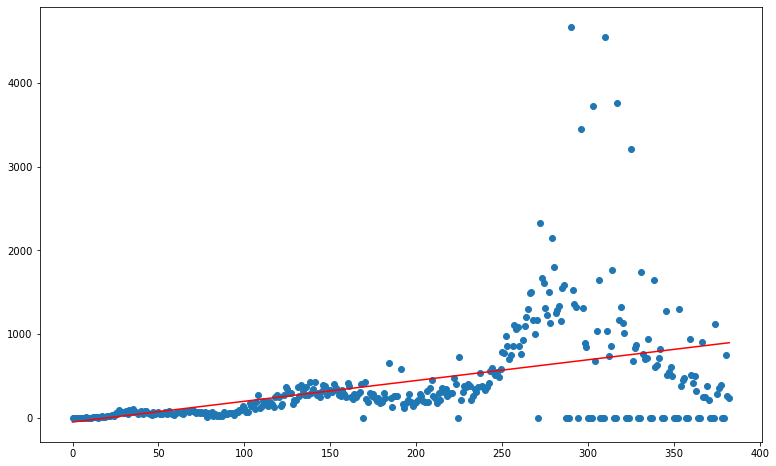

In [5]:
plt.figure(figsize=(8 * 1.618, 8))
plt.scatter(OR_cases2.days, OR_cases2.new_cases)
x = pd.DataFrame({'days': np.linspace(OR_cases2.days.min(), OR_cases2.days.max(), OR_cases2.shape[0])})
x['pred_cases'] = OR_cases_lm.predict(x)
plt.plot(x.days, x.pred_cases, 'r-')
#plt.fill_between(x.days, (x.pred_cases-OR_cases_lm.conf_int().iloc[0,0]), (x.pred_cases-OR_cases_lm.conf_int().iloc[0,1]), color='blue', alpha=0.1)

/Users/Erika/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


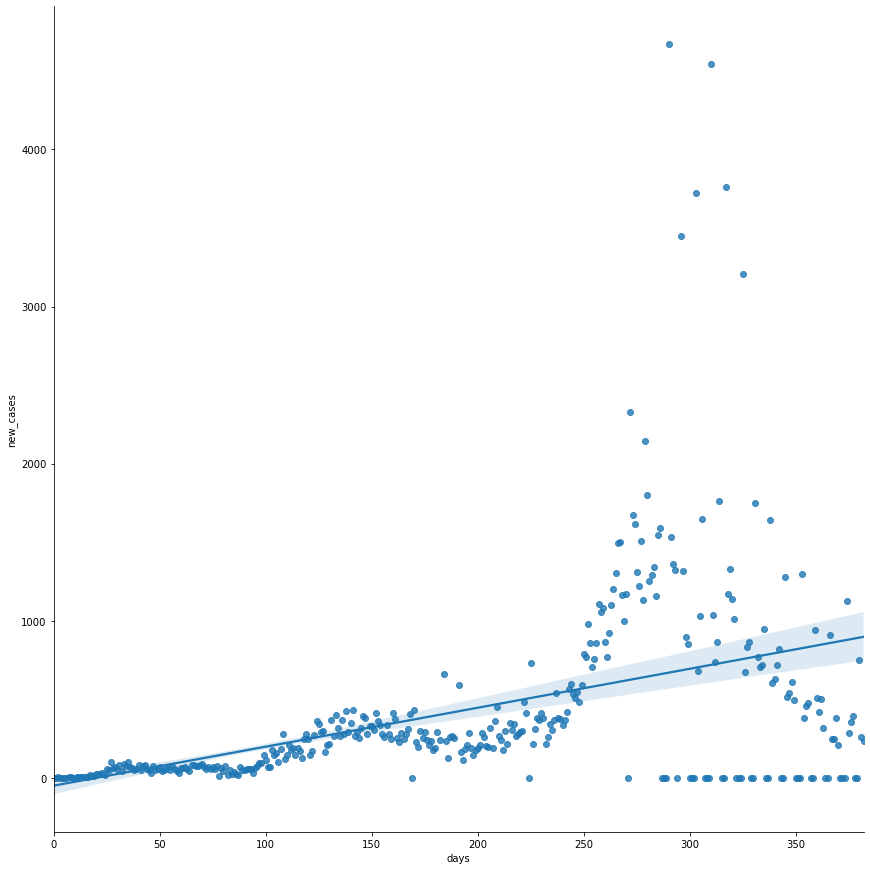

In [6]:
sns.lmplot(x='days', y='new_cases', 
           data=OR_cases2, size=12)

### Linear RMSE

1.) Use the linear model to estimate the number of new cases per day for all days since the first case.  
2.) Calculate the RMSE using these estimates and the actual values.

In [7]:
days = OR_cases2['days']
estimated_cases = []

for day in days:
    estimated_cases.append(math.ceil((OR_cases_params.iloc[0]['days'] * day) + OR_cases_params.iloc[0]['Intercept']))

rmse_OR_cases = mean_squared_error(OR_cases2['new_cases'], estimated_cases, squared = False)
rmse_OR_cases

555.3344084992013

#### Prediction Path
Plot the prediction path for the linear cases model in Oregon for the next week.

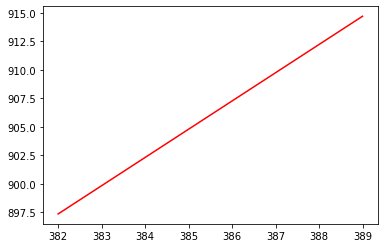

In [8]:
x = pd.DataFrame({'days': np.linspace(OR_cases2.days.max(), (OR_cases2.days.max() + 7))})
x['pred_cases'] = OR_cases_lm.predict(x)
plt.plot(x.days, x.pred_cases, 'r-')

### Polynomial Models for New Cases in Oregon

Find two polynomial models for the new cases data and obtain its parameters.

#### Polynomial 2

In [96]:
polynomial2 = smf.ols(formula = 'new_cases ~  days + I(days ** 2)', data=OR_cases2).fit()
OR_cases_params2 = polynomial2.params.to_frame().transpose()
polynomial2.params

Intercept      -208.580696
days              4.985670
I(days ** 2)     -0.006560
dtype: float64

#### Confidence Intervals

In [97]:
polynomial2.conf_int()

,0,1
Intercept,-374.475687,-42.685704
days,2.974510,6.996830
I(days ** 2),-0.011657,-0.001463


Plot polynomial 2 model.

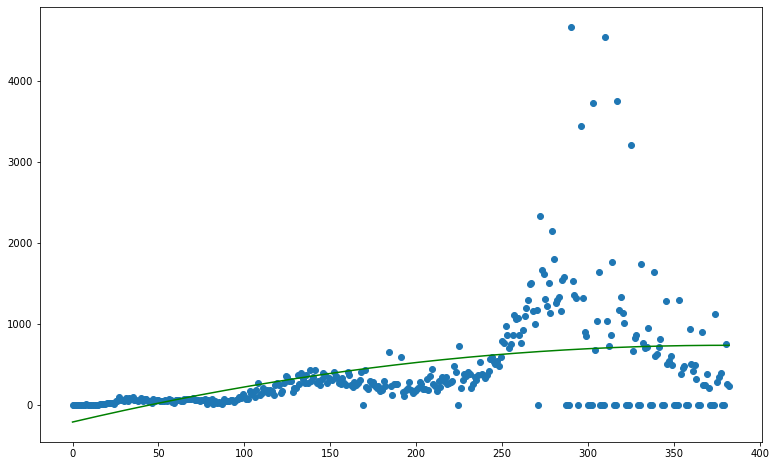

In [98]:
plt.figure(figsize=(8 * 1.618, 8))
plt.scatter(OR_cases2.days, OR_cases2.new_cases)
x = pd.DataFrame({'days': np.linspace(OR_cases2.days.min(), OR_cases2.days.max(), OR_cases2.shape[0])})
plt.plot(x.days, polynomial2.predict(x), 'g-')

#### Polynomial 2 RMSE
Find the RMSE for the second polynomial model.

In [13]:
days = OR_cases2['days']
estimated_cases = []

for day in days:
    estimated_cases.append(math.ceil((OR_cases_params2.iloc[0]['days'] * day) + OR_cases_params2.iloc[0]['Intercept']))


rmse_OR_cases2 = mean_squared_error(OR_cases2['new_cases'], estimated_cases, squared = False)
rmse_OR_cases2

698.513903715746

#### Prediction Path
Plot the prediction path for the polynomial 2 model for cases in Oregon for the next week.

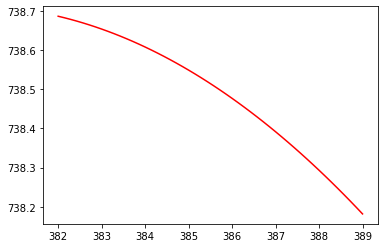

In [14]:
x = pd.DataFrame({'days': np.linspace(OR_cases2.days.max(), (OR_cases2.days.max() + 7))})
x['pred_cases'] = polynomial2.predict(x)
plt.plot(x.days, x.pred_cases, 'r-')

#### Polynomial 3

In [15]:
polynomial3 = smf.ols(formula = 'new_cases ~ days + I(days ** 2) + I(days ** 3)', data=OR_cases2).fit()
OR_cases_params3 = polynomial3.params.to_frame().transpose()
polynomial3.params

Intercept       264.827223
days             -9.991568
I(days ** 2)      0.091612
I(days ** 3)     -0.000171
dtype: float64

#### Confidence Intervals

In [16]:
polynomial3.conf_int()

,0,1
Intercept,56.763917,472.890529
days,-14.718953,-5.264183
I(days ** 2),0.062833,0.120391
I(days ** 3),-0.000221,-0.000122


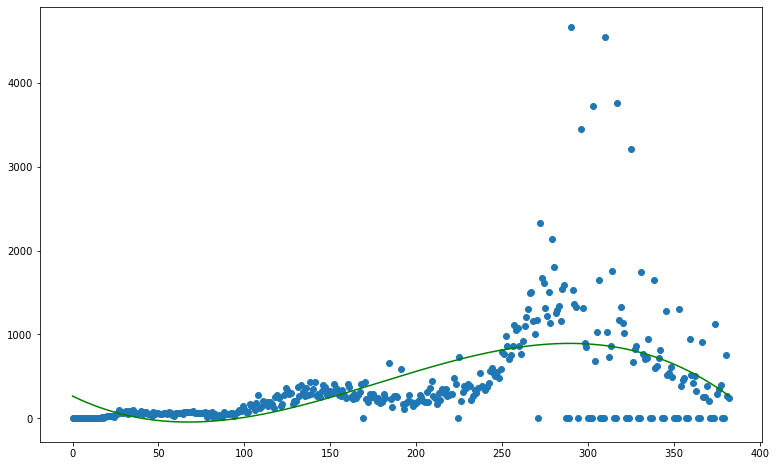

In [17]:
plt.figure(figsize=(8 * 1.618, 8))
plt.scatter(OR_cases2.days, OR_cases2.new_cases)
x = pd.DataFrame({'days': np.linspace(OR_cases2.days.min(), OR_cases2.days.max(), OR_cases2.shape[0])})
plt.plot(x.days, polynomial3.predict(x), 'g-')

#### Polynomial 3 RMSE
Find the RMSE for the third polynomial model.

In [18]:
days = OR_cases2['days']
estimated_cases = []

for day in days:
    estimated_cases.append(math.ceil((OR_cases_params3.iloc[0]['days'] * day) + OR_cases_params3.iloc[0]['Intercept']))

rmse_OR_cases3 = mean_squared_error(OR_cases2['new_cases'], estimated_cases, squared = False)
rmse_OR_cases3

2545.395413393824

#### Prediction Path
Plot the prediction path for the polynomial 3 model for cases in Oregon for the next week.

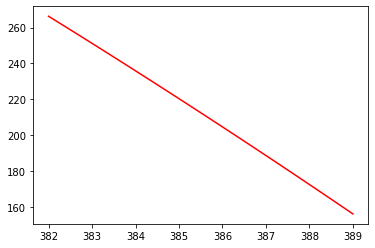

In [19]:
x = pd.DataFrame({'days': np.linspace(OR_cases2.days.max(), (OR_cases2.days.max() + 7))})
x['pred_cases'] = polynomial3.predict(x)
plt.plot(x.days, x.pred_cases, 'r-')

## New Deaths in Oregon

### Linear Model for New Deaths in Oregon

Find the linear model for the new deaths data and obtain its parameters.

In [20]:
OR_deaths_lm = smf.ols(formula='new_deaths ~ days', data=OR_deaths2).fit()
OR_deaths_params = OR_deaths_lm.params.to_frame().transpose()
OR_deaths_lm.params

Intercept   -0.332567
days         0.037157
dtype: float64

#### Confidence Intervals

In [21]:
OR_deaths_lm.conf_int()

,0,1
Intercept,-2.202730,1.537595
days,0.028376,0.045937


#### Plot the new deaths data.

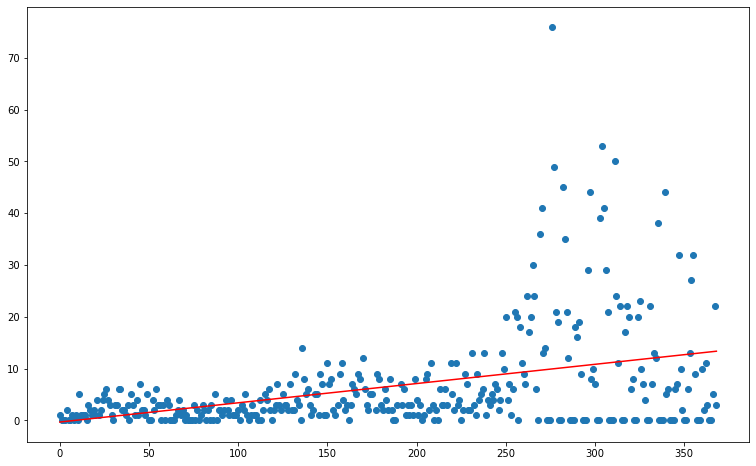

In [22]:
plt.figure(figsize=(8 * 1.618, 8))
plt.scatter(OR_deaths2.days, OR_deaths2.new_deaths)
x = pd.DataFrame({'days': np.linspace(OR_deaths2.days.min(), OR_deaths2.days.max(), OR_deaths2.shape[0])})
x['pred_deaths'] = OR_deaths_lm.predict(x)
plt.plot(x.days, x.pred_deaths, 'r-')

/Users/Erika/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


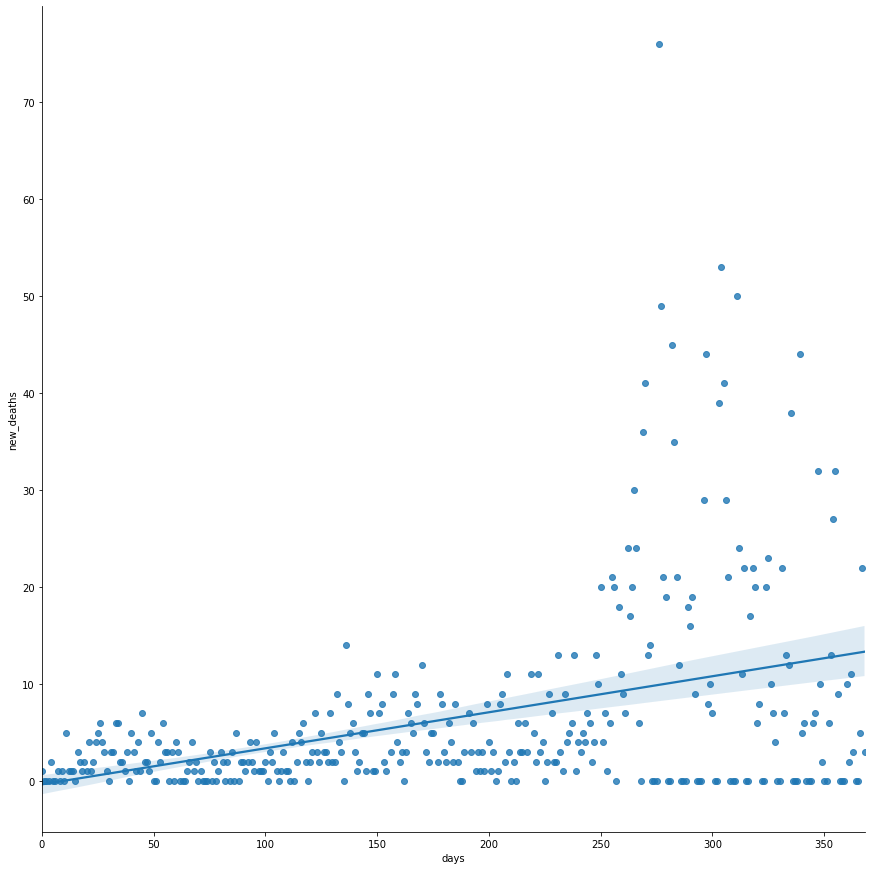

In [23]:
sns.lmplot(x='days', y='new_deaths', 
           data=OR_deaths2, size=12)

### Linear RMSE

1.) Use the linear model to estimate the number of new deaths per day for all days since the first death.  
2.) Calculate the RMSE using these estimates and the actual values.

In [24]:
days2 = OR_deaths2['days']
estimated_deaths = []

for day in days2:
    estimated_deaths.append(math.ceil((OR_deaths_params.iloc[0]['days'] * day) + OR_deaths_params.iloc[0]['Intercept']))

rmse_OR_deaths = mean_squared_error(OR_deaths2['new_deaths'], estimated_deaths, squared = False)
rmse_OR_deaths

9.14324346711281

#### Prediction Path
Plot the prediction path for the linear model for deaths in Oregon for the next week.

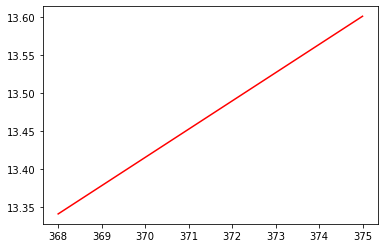

In [25]:
x = pd.DataFrame({'days': np.linspace(OR_deaths2.days.max(), (OR_deaths2.days.max() + 7))})
x['pred_deaths'] = OR_deaths_lm.predict(x)
plt.plot(x.days, x.pred_deaths, 'r-')

### Polynomial Models for New Deaths in Oregon

Find two polynomial models for the new deaths data and obtain its parameters.

#### Polynomial 2

In [26]:
polynomial2 = smf.ols(formula = 'new_deaths ~  days + I(days ** 2)', data=OR_deaths2).fit()
OR_deaths_params2 = polynomial2.params.to_frame().transpose()
polynomial2.params

Intercept      -0.083639
days            0.033059
I(days ** 2)    0.000011
dtype: float64

#### Confidence Intervals

In [27]:
polynomial2.conf_int()

,0,1
Intercept,-2.881485,2.714207
days,-0.002271,0.068390
I(days ** 2),-0.000082,0.000104


#### Plot polynomial 2 model.

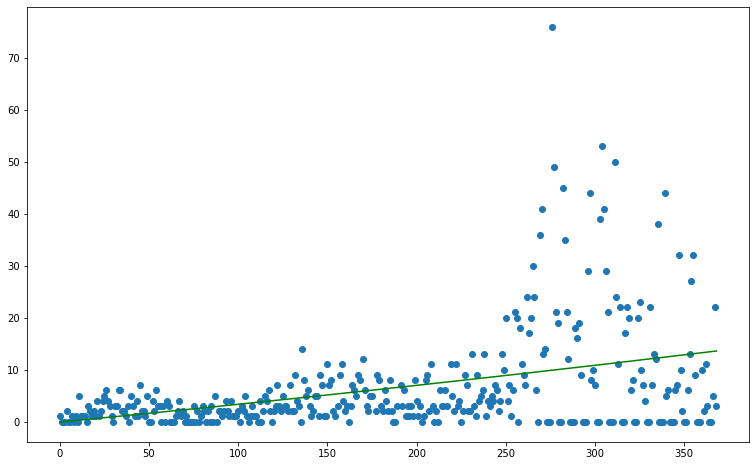

In [28]:
plt.figure(figsize=(8 * 1.618, 8))
plt.scatter(OR_deaths2.days, OR_deaths2.new_deaths)
x = pd.DataFrame({'days': np.linspace(OR_deaths2.days.min(), OR_deaths2.days.max(), OR_deaths2.shape[0])})
plt.plot(x.days, polynomial2.predict(x), 'g-')

#### Polynomial 2 RMSE
Find the RMSE for the second polynomial model.

In [29]:
days2 = OR_deaths2['days']
estimated_deaths = []

for day in days2:
    estimated_deaths.append(math.ceil((OR_deaths_params2.iloc[0]['days'] * day) + OR_deaths_params2.iloc[0]['Intercept']))

rmse_OR_deaths2 = mean_squared_error(OR_deaths2['new_deaths'], estimated_deaths, squared = False)
rmse_OR_deaths2

9.118571798716708

#### Prediction Path
Plot the prediction path for the next week.

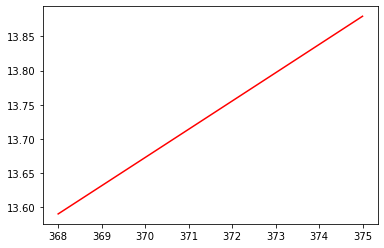

In [30]:
x = pd.DataFrame({'days': np.linspace(OR_deaths2.days.max(), (OR_deaths2.days.max() + 7))})
x['pred_deaths'] = polynomial2.predict(x)
plt.plot(x.days, x.pred_deaths, 'r-')

#### Polynomial 3

In [31]:
polynomial3 = smf.ols(formula = 'new_deaths ~  days + I(days ** 2) + I(days ** 3)', data=OR_deaths2).fit()
OR_deaths_params3 = polynomial3.params.to_frame().transpose()
polynomial3.params

Intercept       4.755267
days           -0.125902
I(days ** 2)    0.001092
I(days ** 3)   -0.000002
dtype: float64

#### Confidence Intervals

In [32]:
polynomial3.conf_int()

,0,1
Intercept,1.117124,8.393411e+00
days,-0.211743,-4.006122e-02
I(days ** 2),0.000550,1.634397e-03
I(days ** 3),-0.000003,-9.907528e-07


#### Plot polynomial3 model.

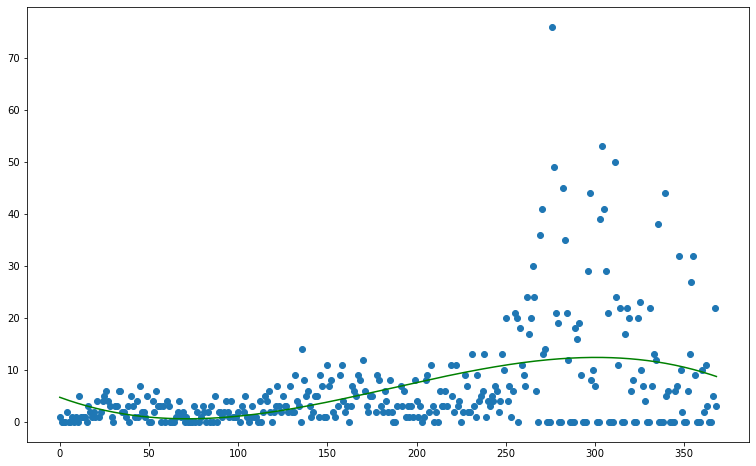

In [33]:
plt.figure(figsize=(8 * 1.618, 8))
plt.scatter(OR_deaths2.days, OR_deaths2.new_deaths)
x = pd.DataFrame({'days': np.linspace(OR_deaths2.days.min(), OR_deaths2.days.max(), OR_deaths2.shape[0])})
plt.plot(x.days, polynomial3.predict(x), 'g-')

#### Polynomial 3 RMSE
Find the RMSE for the second polynomial model.

In [34]:
days3 = OR_deaths2['days']
estimated_deaths = []

for day in days3:
    estimated_deaths.append(math.ceil((OR_deaths_params3.iloc[0]['days'] * day) + OR_deaths_params3.iloc[0]['Intercept']))

rmse_OR_deaths3 = mean_squared_error(OR_deaths2['new_deaths'], estimated_deaths, squared = False)
rmse_OR_deaths3

31.384184440049307

#### Prediction Path
Plot the prediction path for the next week.

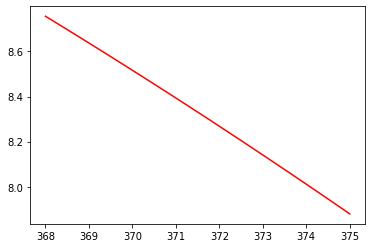

In [35]:
x = pd.DataFrame({'days': np.linspace(OR_deaths2.days.max(), (OR_deaths2.days.max() + 7))})
x['pred_deaths'] = polynomial3.predict(x)
plt.plot(x.days, x.pred_deaths, 'r-')

### Identify Top 5 Counties at Risk in Oregon 

In [36]:
OR = super_dataset[super_dataset['StateFIPS'] == 41]

OR_cases_rate = (OR[OR.columns[-2]] / OR['population']) * 100000
OR['cases_rate'] = np.ceil(OR_cases_rate).replace(np.inf, np.nan)
OR.nlargest(5, 'cases_rate')

<ipython-input-36-db320c80732e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OR['cases_rate'] = np.ceil(OR_cases_rate).replace(np.inf, np.nan)


,countyFIPS,County Name,State,StateFIPS,population,2020-01-22_cases,2020-01-22_deaths,2020-01-23_cases,2020-01-23_deaths,2020-01-24_cases,...,2021-03-13_deaths,2021-03-14_cases,2021-03-14_deaths,2021-03-15_cases,2021-03-15_deaths,2021-03-16_cases,2021-03-16_deaths,2021-03-17_cases,2021-03-17_deaths,cases_rate
2268,41045,Malheur County,OR,41,30571,0,0,0,0,0,...,58,3371,58,3373,58,3373,58,3376,58,11044.0
2275,41059,Umatilla County,OR,41,77950,0,0,0,0,0,...,82,7748,82,7757,82,7775,82,7788,82,9992.0
2270,41049,Morrow County,OR,41,11603,0,0,0,0,0,...,14,1053,14,1054,14,1054,14,1055,14,9093.0
2261,41031,Jefferson County,OR,41,24658,0,0,0,0,0,...,30,1990,30,1992,30,1994,31,1996,31,8095.0
2269,41047,Marion County,OR,41,347818,0,0,0,0,0,...,290,18816,290,18879,290,18914,292,18939,292,5446.0


Drop the cases rate column to prevent using it in the models.

In [37]:
OR = OR.drop('cases_rate', axis=1)

### Cases Functions
Function to return a county's new cases from the first day of infections.

In [38]:
def county_cases(county):
    county_cases = county[county.columns[5::2]]
    
    first_day_cases = county_cases.sum() > 0
    first_day_cases = first_day_cases[first_day_cases]
    first_day_cases = first_day_cases.index[0]
    
    county_cases = county_cases.loc[:, first_day_cases:county_cases.columns[-1]]
    
    county_cases2 = county_cases.diff(axis=1)
    county_cases2[first_day_cases] = county_cases[first_day_cases]
    county_cases2 = county_cases2.sum(axis=0)
    county_cases2 = county_cases2.to_frame()
    county_cases2 = county_cases2.reset_index()
    county_cases2['days'] = county_cases2.index
    county_cases2.rename(columns={0:'new_cases'}, inplace=True)
    county_cases2 = county_cases2[(county_cases2.new_cases >= 0)]
    county_cases2['new_cases'] = (county_cases2['new_cases'] / county['population'].mean()) * 100000
    
    return county_cases2

Function that prints out the linear regression model and its parameters.

In [39]:
def county_cases_linear(county):
    # Print linear model
    county_cases_lm = smf.ols(formula='new_cases ~ days', data=county).fit()
    county_cases_params = county_cases_lm.params.to_frame().transpose()
    print('Linear model parameters:\n', county_cases_lm.params)
    print('\nConfidence Intervals:\n', county_cases_lm.conf_int())
        
    days = county['days']
    estimated_cases = []

    for day in days:
        estimated_cases.append(math.ceil((county_cases_params.iloc[0]['days'] * day) + county_cases_params.iloc[0]['Intercept']))

    rmse_OR_cases = mean_squared_error(county['new_cases'], estimated_cases, squared = False)
    print('\nRMSE: ', rmse_OR_cases)
    
    plt.figure(figsize=(5 * 1.618, 5))
    plt.scatter(county.days, county.new_cases)
    x = pd.DataFrame({'days': np.linspace(county.days.min(), county.days.max(), county.shape[0])})
    x['pred_cases'] = county_cases_lm.predict(x)
    plt.title("Linear Model")
    plt.plot(x.days, x.pred_cases, 'r-')
    
    sns.lmplot(x='days', y='new_cases', 
           data=county, size=12)
    
    x2 = pd.DataFrame({'days': np.linspace(county.days.max(), (county.days.max() + 7))})
    x2['pred_cases'] = county_cases_lm.predict(x2)
    fig2, ax2 = plt.subplots()
    ax2.set_title("Prediction Path")
    ax2.plot(x2.days, x2.pred_cases)

Function that prints out the polynomial 2 model and its parameters.

In [40]:
def county_cases_poly2(county):
    # Print polynomial models
    # Polynomial 2
    polynomial2 = smf.ols(formula = 'new_cases ~  days + I(days ** 2)', data=county).fit()
    county_cases_params2 = polynomial2.params.to_frame().transpose()
    print('Polynomial 2 model parameters:\n', polynomial2.params)
    print('\nConfidence Intervals:\n', polynomial2.conf_int())
    
    days = county['days']
    estimated_cases = []

    for day in days:
        estimated_cases.append(math.ceil((county_cases_params2.iloc[0]['days'] * day) + county_cases_params2.iloc[0]['Intercept']))

    rmse_OR_cases = mean_squared_error(county['new_cases'], estimated_cases, squared = False)
    print('\nRMSE: ', rmse_OR_cases)
    
    plt.figure(figsize=(5 * 1.618, 5))
    plt.scatter(county.days, county.new_cases)
    x = pd.DataFrame({'days': np.linspace(county.days.min(), county.days.max(), county.shape[0])})
    plt.title("Polynomial 2 Model")
    plt.plot(x.days, polynomial2.predict(x), 'g-')
    
    x2 = pd.DataFrame({'days': np.linspace(county.days.max(), (county.days.max() + 7))})
    x2['pred_cases'] = polynomial2.predict(x2)
    fig2, ax2 = plt.subplots()
    ax2.set_title("Prediction Path")
    ax2.plot(x2.days, x2.pred_cases)  

Function that prints out the polynomial 3 model and its parameters.

In [41]:
def county_cases_poly3(county):
    # Polynomial 3
    polynomial3 = smf.ols(formula = 'new_cases ~  days + I(days ** 2) + I(days ** 3)', data=county).fit()
    county_cases_params3 = polynomial3.params.to_frame().transpose()
    print('Polynomial 3 model parameters:\n', polynomial3.params)
    print('\nConfidence Intervals:\n', polynomial3.conf_int())
    
    days = county['days']
    estimated_cases = []

    for day in days:
        estimated_cases.append(math.ceil((county_cases_params3.iloc[0]['days'] * day) + county_cases_params3.iloc[0]['Intercept']))

    rmse_OR_cases = mean_squared_error(county['new_cases'], estimated_cases, squared = False)
    print('\nRMSE: ', rmse_OR_cases)
    
    plt.figure(figsize=(5 * 1.618, 5))
    plt.scatter(county.days, county.new_cases)
    x = pd.DataFrame({'days': np.linspace(county.days.min(), county.days.max(), county.shape[0])})
    plt.title("Polynomial 3 Model")
    plt.plot(x.days, polynomial3.predict(x), 'g-')
    
    x2 = pd.DataFrame({'days': np.linspace(county.days.max(), (county.days.max() + 7))})
    x2['pred_cases'] = polynomial3.predict(x2)
    fig2, ax2 = plt.subplots()
    ax2.set_title("Prediction Path")
    ax2.plot(x2.days, x2.pred_cases)

### Deaths Functions
Function to return a county's new deaths from the first day of infections.

In [42]:
def county_deaths(county):
    county_deaths = county[county.columns[6::2]]
    
    first_day_deaths = county_deaths.sum() > 0
    first_day_deaths = first_day_deaths[first_day_deaths]
    first_day_deaths = first_day_deaths.index[0]
    
    county_deaths = county_deaths.loc[:, first_day_deaths:county_deaths.columns[-1]]
    
    county_deaths2 = county_deaths.diff(axis=1)
    county_deaths2[first_day_deaths] = county_deaths[first_day_deaths]
    county_deaths2 = county_deaths2.sum(axis=0)
    county_deaths2 = county_deaths2.to_frame()
    county_deaths2 = county_deaths2.reset_index()
    county_deaths2['days'] = county_deaths2.index
    county_deaths2.rename(columns={0:'new_deaths'}, inplace=True)
    county_deaths2 = county_deaths2[(county_deaths2.new_deaths >= 0)]
    county_deaths2['new_deaths'] = (county_deaths2['new_deaths'] / county['population'].mean()) * 100000

    return county_deaths2

Function that prints out the linear regression model and its parameters.

In [43]:
def county_deaths_linear(county):
    # Print linear model
    county_deaths_lm = smf.ols(formula='new_deaths ~ days', data=county).fit()
    county_deaths_params = county_deaths_lm.params.to_frame().transpose()
    print('Linear model parameters:\n', county_deaths_lm.params)
    print('\nConfidence Intervals:\n', county_deaths_lm.conf_int())
    
    days = county['days']
    estimated_deaths = []

    for day in days:
        estimated_deaths.append(math.ceil((county_deaths_params.iloc[0]['days'] * day) + county_deaths_params.iloc[0]['Intercept']))

    rmse_OR_deaths = mean_squared_error(county['new_deaths'], estimated_deaths, squared = False)
    print('\nRMSE: ', rmse_OR_deaths)
    
    plt.figure(figsize=(5 * 1.618, 5))
    plt.scatter(county.days, county.new_deaths)
    x = pd.DataFrame({'days': np.linspace(county.days.min(), county.days.max(), county.shape[0])})
    x['pred_deaths'] = county_deaths_lm.predict(x)
    plt.title("Linear Model")
    plt.plot(x.days, x.pred_deaths, 'r-')
    
    sns.lmplot(x='days', y='new_deaths', 
           data=county, size=12)
    
    x2 = pd.DataFrame({'days': np.linspace(county.days.max(), (county.days.max() + 7))})
    x2['pred_deaths'] = county_deaths_lm.predict(x2)
    fig2, ax2 = plt.subplots()
    ax2.set_title("Prediction Path")
    ax2.plot(x2.days, x2.pred_deaths)

Function that prints out the polynomial 2 model and its parameters.

In [44]:
def county_deaths_poly2(county):
    # Print polynomial models
    # Polynomial 2
    polynomial2 = smf.ols(formula = 'new_deaths ~  days + I(days ** 2)', data=county).fit()
    county_deaths_params2 = polynomial2.params.to_frame().transpose()
    print('Polynomial 2 model parameters:\n', polynomial2.params)
    print('\nConfidence Intervals:\n', polynomial2.conf_int())
    
    days = county['days']
    estimated_deaths = []

    for day in days:
        estimated_deaths.append(math.ceil((county_deaths_params2.iloc[0]['days'] * day) + county_deaths_params2.iloc[0]['Intercept']))

    rmse_OR_deaths = mean_squared_error(county['new_deaths'], estimated_deaths, squared = False)
    print('\nRMSE: ', rmse_OR_deaths)
    
    
    plt.figure(figsize=(5 * 1.618, 5))
    plt.scatter(county.days, county.new_deaths)
    x = pd.DataFrame({'days': np.linspace(county.days.min(), county.days.max(), county.shape[0])})
    plt.title("Polynomial 2 Model")
    plt.plot(x.days, polynomial2.predict(x), 'g-')
    
    x2 = pd.DataFrame({'days': np.linspace(county.days.max(), (county.days.max() + 7))})
    x2['pred_deaths'] = polynomial2.predict(x2)
    fig2, ax2 = plt.subplots()
    ax2.set_title("Prediction Path")
    ax2.plot(x2.days, x2.pred_deaths)

Function that prints out the polynomial 3 model and its parameters.

In [45]:
def county_deaths_poly3(county):
    # Polynomial 3
    polynomial3 = smf.ols(formula = 'new_deaths ~  days + I(days ** 2) + I(days ** 3)', data=county).fit()
    county_deaths_params3 = polynomial3.params.to_frame().transpose()
    print('Polynomial 3 model parameters:\n', polynomial3.params)
    print('\nConfidence Intervals:\n', polynomial3.conf_int())
    
    days = county['days']
    estimated_deaths = []

    for day in days:
        estimated_deaths.append(math.ceil((county_deaths_params3.iloc[0]['days'] * day) + county_deaths_params3.iloc[0]['Intercept']))

    rmse_OR_deaths = mean_squared_error(county['new_deaths'], estimated_deaths, squared = False)
    print('\nRMSE: ', rmse_OR_deaths)
    
    
    plt.figure(figsize=(5 * 1.618, 5))
    plt.scatter(county.days, county.new_deaths)
    x = pd.DataFrame({'days': np.linspace(county.days.min(), county.days.max(), county.shape[0])})
    plt.title("Polynomial 3 Model")
    plt.plot(x.days, polynomial3.predict(x), 'g-')
    
    x2 = pd.DataFrame({'days': np.linspace(county.days.max(), (county.days.max() + 7))})
    x2['pred_deaths'] = polynomial3.predict(x2)
    fig2, ax2 = plt.subplots()
    ax2.set_title("Prediction Path")
    ax2.plot(x2.days, x2.pred_deaths)

### Counties

#### Malheur County Cases
Malheur County cases seem to be rising based off of the linear model, but based on both polynomial models, the cases seem to be decreasing.

Linear model parameters:
 Intercept    22.972669
days          0.051886
dtype: float64

Confidence Intervals:
                    0          1
Intercept  15.376858  30.568481
days        0.014474   0.089298

RMSE:  36.167089557142646


/Users/Erika/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


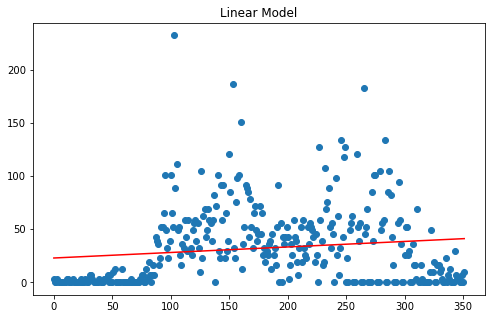

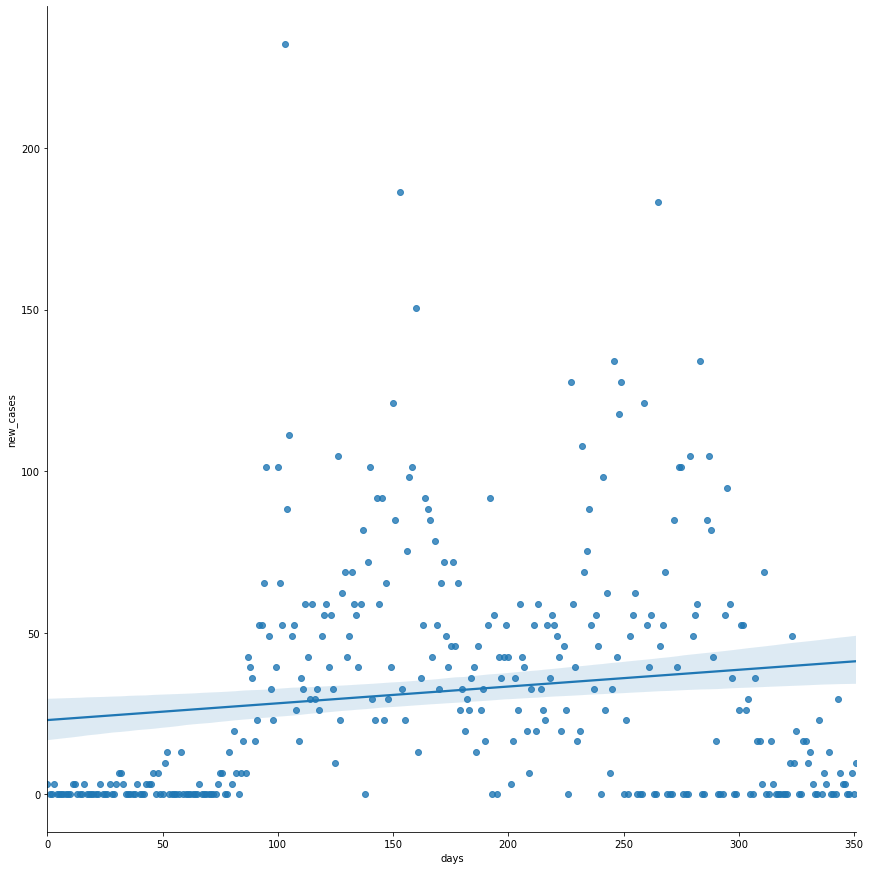

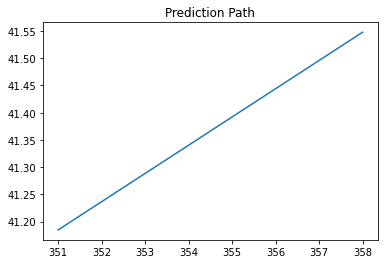

In [46]:
county_cases_linear(county_cases(OR[OR['countyFIPS'] == 41045]))

Polynomial 2 model parameters:
 Intercept      -18.336042
days             0.762447
I(days ** 2)    -0.002025
dtype: float64

Confidence Intervals:
                       0         1
Intercept    -28.059334 -8.612750
days           0.634161  0.890734
I(days ** 2)  -0.002379 -0.001671

RMSE:  116.6145765625502


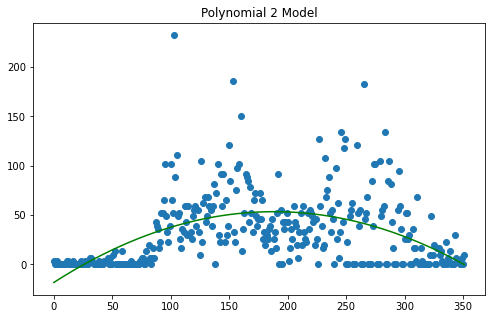

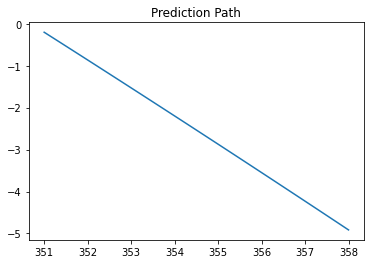

In [47]:
county_cases_poly2(county_cases(OR[OR['countyFIPS'] == 41045]))

Polynomial 3 model parameters:
 Intercept      -15.405160
days             0.661518
I(days ** 2)    -0.001306
I(days ** 3)    -0.000001
dtype: float64

Confidence Intervals:
                       0         1
Intercept    -28.322579 -2.487741
days           0.342041  0.980995
I(days ** 2)  -0.003421  0.000810
I(days ** 3)  -0.000005  0.000003

RMSE:  99.75918805825528


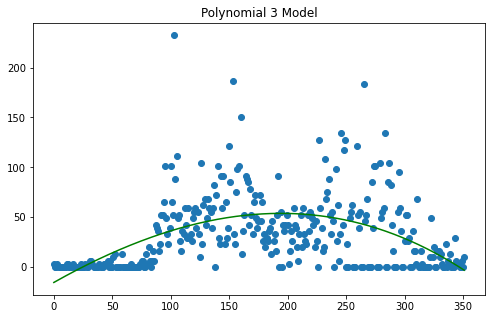

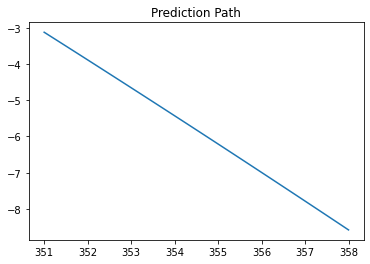

In [48]:
county_cases_poly3(county_cases(OR[OR['countyFIPS'] == 41045]))

#### Malheur County Deaths
According to the linear model and both polynomial models, the number of new deaths in malheur county are decreasing.

Linear model parameters:
 Intercept    0.963323
days        -0.001874
dtype: float64

Confidence Intervals:
                   0         1
Intercept  0.541380  1.385265
days      -0.004458  0.000709

RMSE:  1.8261287891685944


/Users/Erika/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


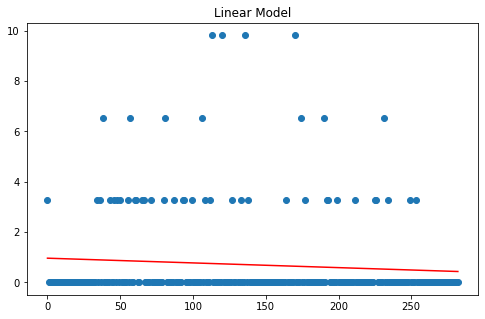

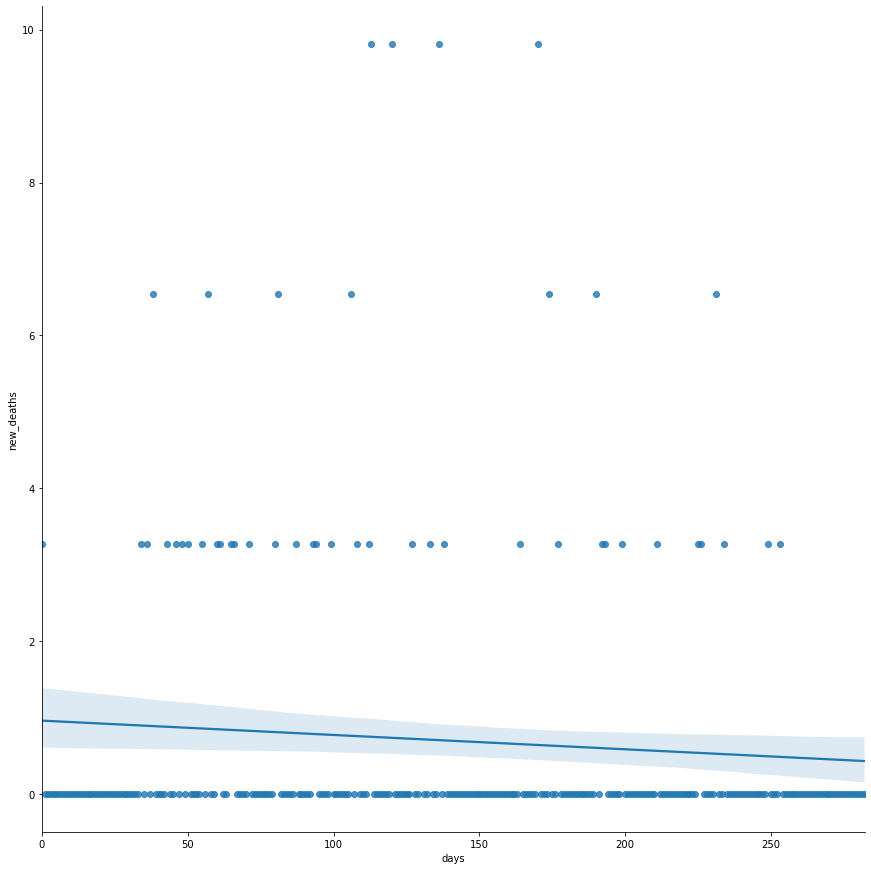

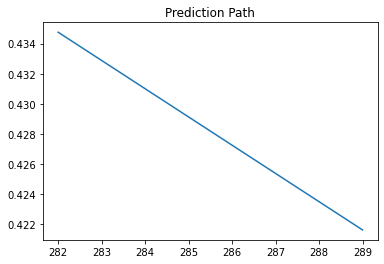

In [49]:
county_deaths_linear(county_deaths(OR[OR['countyFIPS'] == 41045]))

Polynomial 2 model parameters:
 Intercept       0.382208
days            0.010564
I(days ** 2)   -0.000044
dtype: float64

Confidence Intervals:
                      0         1
Intercept    -0.240734  1.005149
days          0.000354  0.020775
I(days ** 2) -0.000079 -0.000009

RMSE:  2.6911700749068506


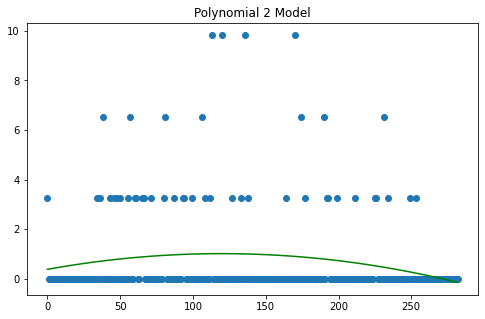

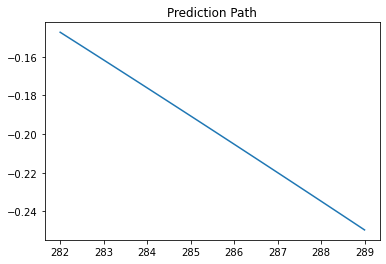

In [50]:
county_deaths_poly2(county_deaths(OR[OR['countyFIPS'] == 41045]))

Polynomial 3 model parameters:
 Intercept       9.239584e-02
days            2.304865e-02
I(days ** 2)   -1.549903e-04
I(days ** 3)    2.620284e-07
dtype: float64

Confidence Intervals:
                          0             1
Intercept    -7.322010e-01  9.169927e-01
days         -2.370814e-03  4.846811e-02
I(days ** 2) -3.646821e-04  5.470155e-05
I(days ** 3) -2.265809e-07  7.506376e-07

RMSE:  4.177284786606646


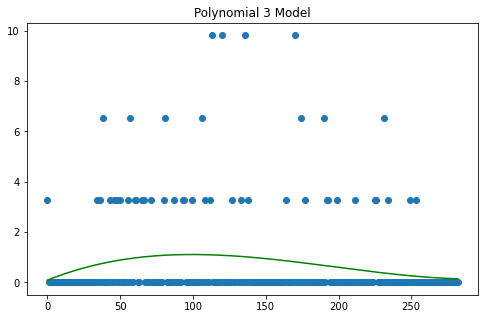

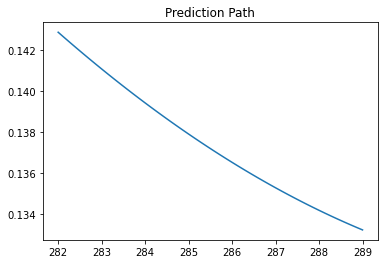

In [51]:
county_deaths_poly3(county_deaths(OR[OR['countyFIPS'] == 41045]))

#### Umatilla County Cases
Looking at the linear model, the new cases in Umatilla County are increasing. The polynomial models indicate the number of new cases is decreasing.

Linear model parameters:
 Intercept    7.161345
days         0.101608
dtype: float64

Confidence Intervals:
                   0          1
Intercept  0.058652  14.264038
days       0.069280   0.133936

RMSE:  35.1991640783856


/Users/Erika/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


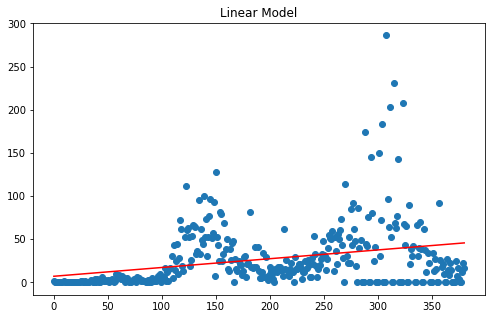

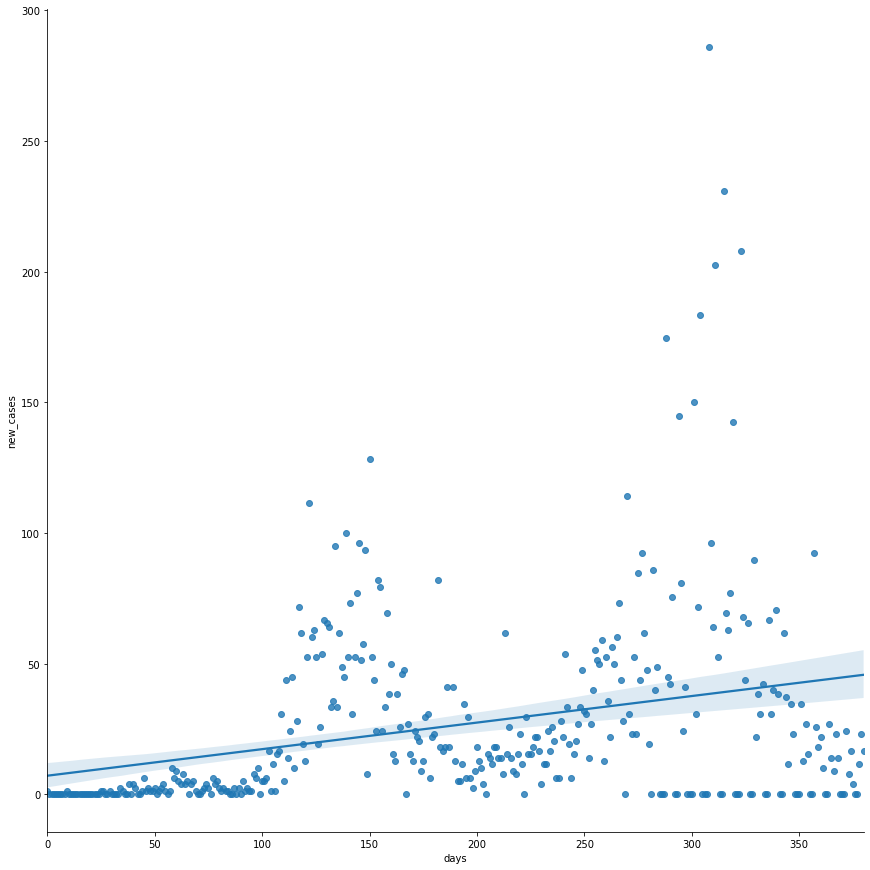

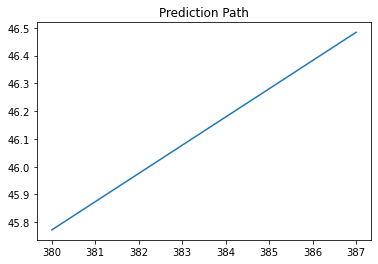

In [52]:
county_cases_linear(county_cases(OR[OR['countyFIPS'] == 41059]))

Polynomial 2 model parameters:
 Intercept      -10.976517
days             0.389558
I(days ** 2)    -0.000758
dtype: float64

Confidence Intervals:
                       0         1
Intercept    -21.315716 -0.637318
days           0.263561  0.515556
I(days ** 2)  -0.001079 -0.000437

RMSE:  60.17821885407332


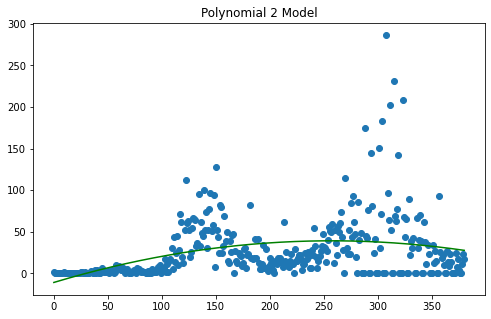

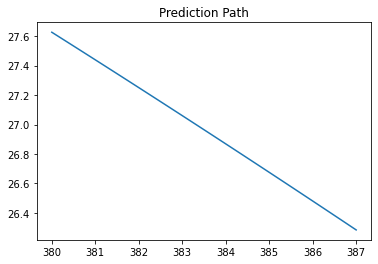

In [53]:
county_cases_poly2(county_cases(OR[OR['countyFIPS'] == 41059]))

Polynomial 3 model parameters:
 Intercept      -2.474263
days            0.119297
I(days ** 2)    0.001022
I(days ** 3)   -0.000003
dtype: float64

Confidence Intervals:
                       0             1
Intercept    -16.151259  1.120273e+01
days          -0.192901  4.314955e-01
I(days ** 2)  -0.000887  2.931838e-03
I(days ** 3)  -0.000006  1.798100e-07

RMSE:  35.7070739925413


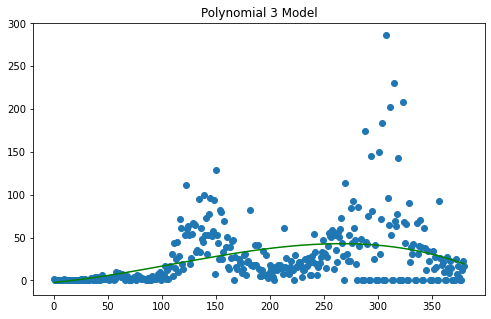

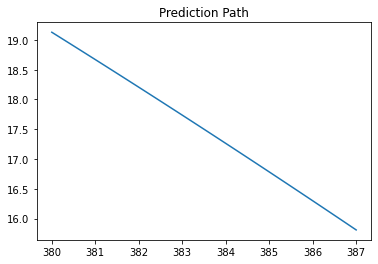

In [54]:
county_cases_poly3(county_cases(OR[OR['countyFIPS'] == 41059]))

#### Umatilla County Deaths
The linear and polynomial 3 models indicate that the number of new deaths in Umatilla County are increasing, while the polynomial 2 model indicates the number of new deaths is decreasing.

Linear model parameters:
 Intercept    0.298305
days         0.000222
dtype: float64

Confidence Intervals:
                   0         1
Intercept  0.132805  0.463805
days      -0.000675  0.001119

RMSE:  1.0041265343269765


/Users/Erika/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


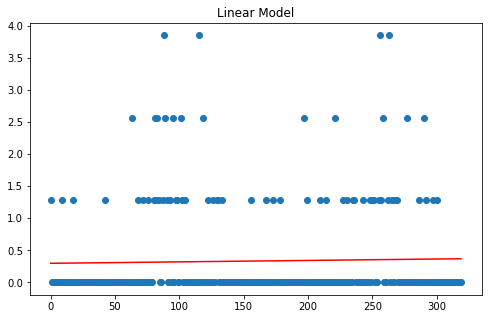

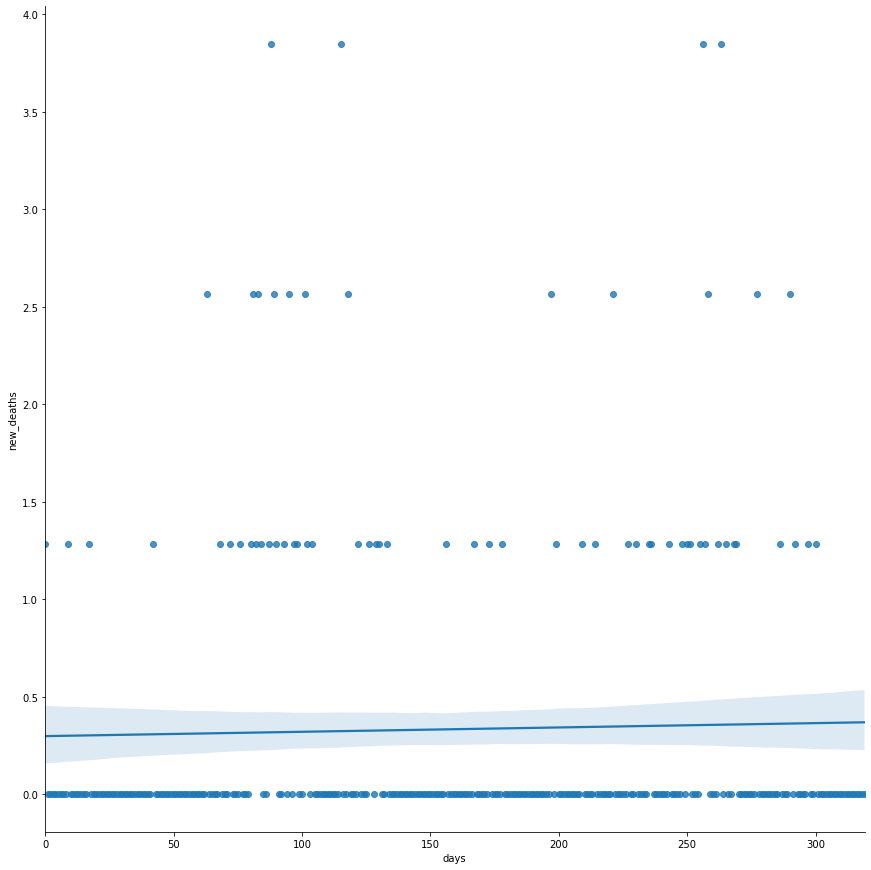

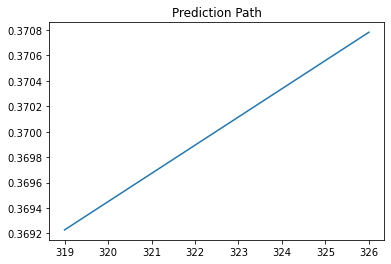

In [55]:
county_deaths_linear(county_deaths(OR[OR['countyFIPS'] == 41059]))

Polynomial 2 model parameters:
 Intercept       0.166650
days            0.002711
I(days ** 2)   -0.000008
dtype: float64

Confidence Intervals:
                      0         1
Intercept    -0.080011  0.413312
days         -0.000865  0.006287
I(days ** 2) -0.000019  0.000003

RMSE:  1.0588308465077447


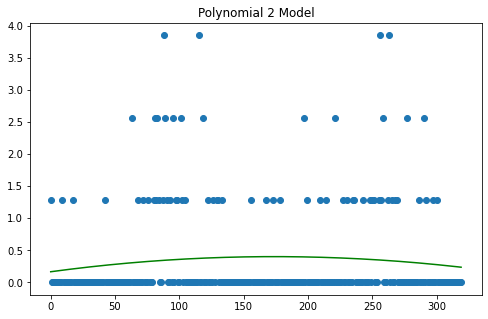

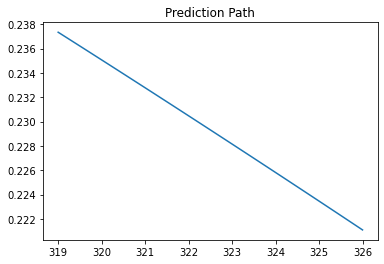

In [56]:
county_deaths_poly2(county_deaths(OR[OR['countyFIPS'] == 41059]))

Polynomial 3 model parameters:
 Intercept       6.959250e-02
days            6.392522e-03
I(days ** 2)   -3.668546e-05
I(days ** 3)    6.033385e-08
dtype: float64

Confidence Intervals:
                          0             1
Intercept    -2.578100e-01  3.969950e-01
days         -2.519052e-03  1.530410e-02
I(days ** 2) -1.016340e-04  2.826305e-05
I(days ** 3) -7.343641e-08  1.941041e-07

RMSE:  1.6115205564134634


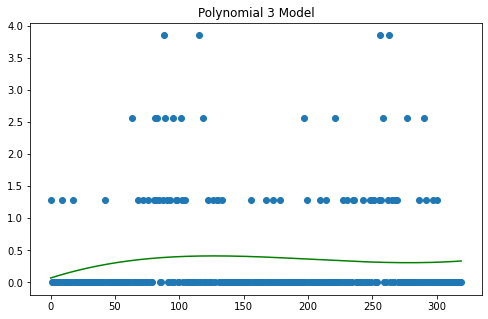

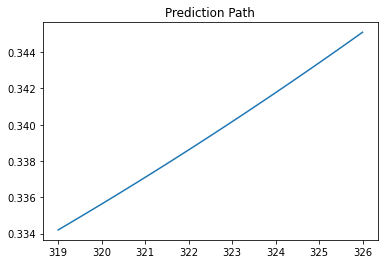

In [57]:
county_deaths_poly3(county_deaths(OR[OR['countyFIPS'] == 41059]))

#### Morrow County Cases
The linear model indicates that the number of new cases in Morrow County are increasing, while the polynomial models indicate the number of new cases is increasing.

Linear model parameters:
 Intercept    16.939257
days          0.053126
dtype: float64

Confidence Intervals:
                   0          1
Intercept  9.120493  24.758021
days       0.015064   0.091189

RMSE:  37.30709206894797


/Users/Erika/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


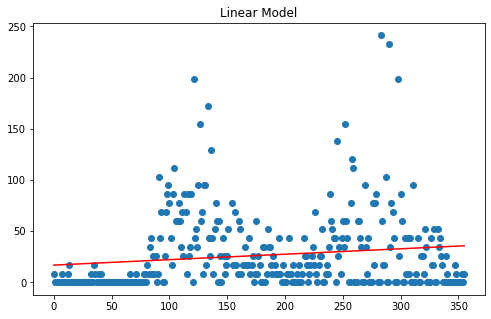

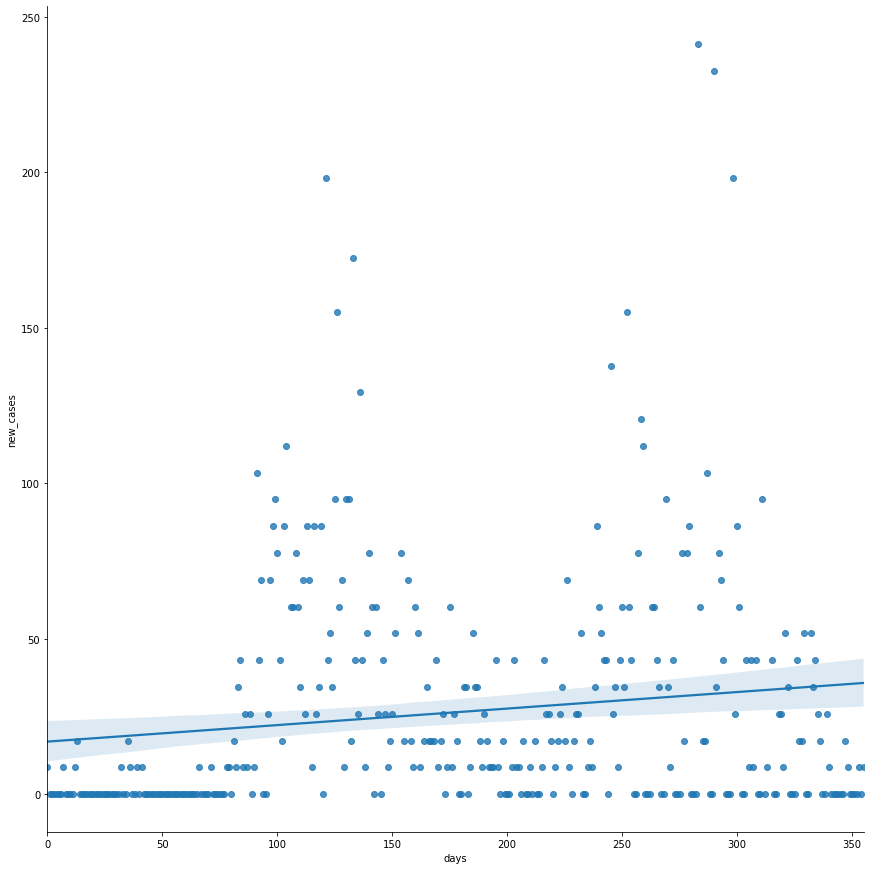

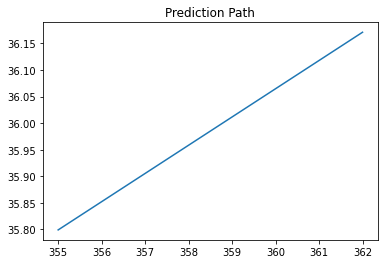

In [58]:
county_cases_linear(county_cases(OR[OR['countyFIPS'] == 41049]))

Polynomial 2 model parameters:
 Intercept      -6.041399
days            0.446049
I(days ** 2)   -0.001109
dtype: float64

Confidence Intervals:
                       0         1
Intercept    -17.227651  5.144852
days           0.299723  0.592376
I(days ** 2)  -0.001509 -0.000709

RMSE:  72.61588391330085


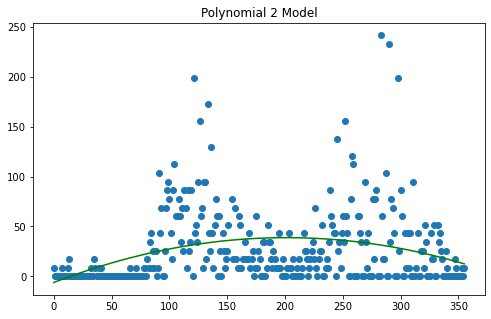

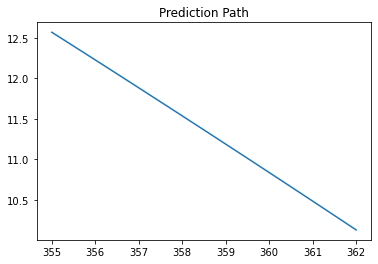

In [59]:
county_cases_poly2(county_cases(OR[OR['countyFIPS'] == 41049]))

Polynomial 3 model parameters:
 Intercept      -9.774561
days            0.573395
I(days ** 2)   -0.002005
I(days ** 3)    0.000002
dtype: float64

Confidence Intervals:
                       0         1
Intercept    -24.647354  5.098232
days           0.208649  0.938141
I(days ** 2)  -0.004391  0.000381
I(days ** 3)  -0.000003  0.000006

RMSE:  93.04485697435715


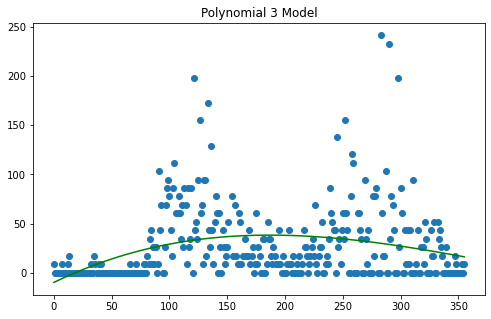

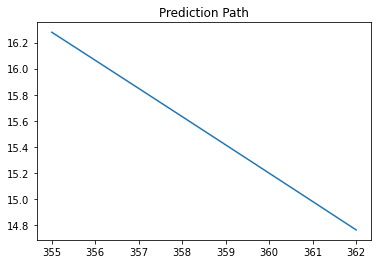

In [60]:
county_cases_poly3(county_cases(OR[OR['countyFIPS'] == 41049]))

#### Morrow County Deaths
The linear and polynomial 2 models indicate that the number of new deaths in Morrow County are increasing, while the polynomial 3 model indicates that the number of new deaths is decreasing.

Linear model parameters:
 Intercept    0.596354
days        -0.000617
dtype: float64

Confidence Intervals:
                   0         1
Intercept  0.103050  1.089658
days      -0.003767  0.002534

RMSE:  2.095893582407053


/Users/Erika/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


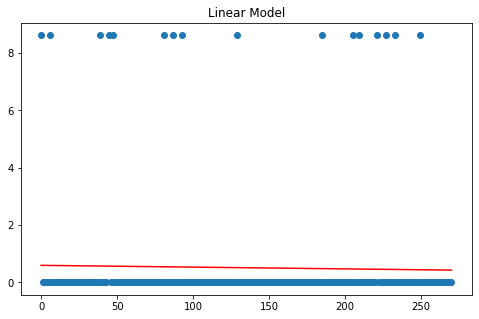

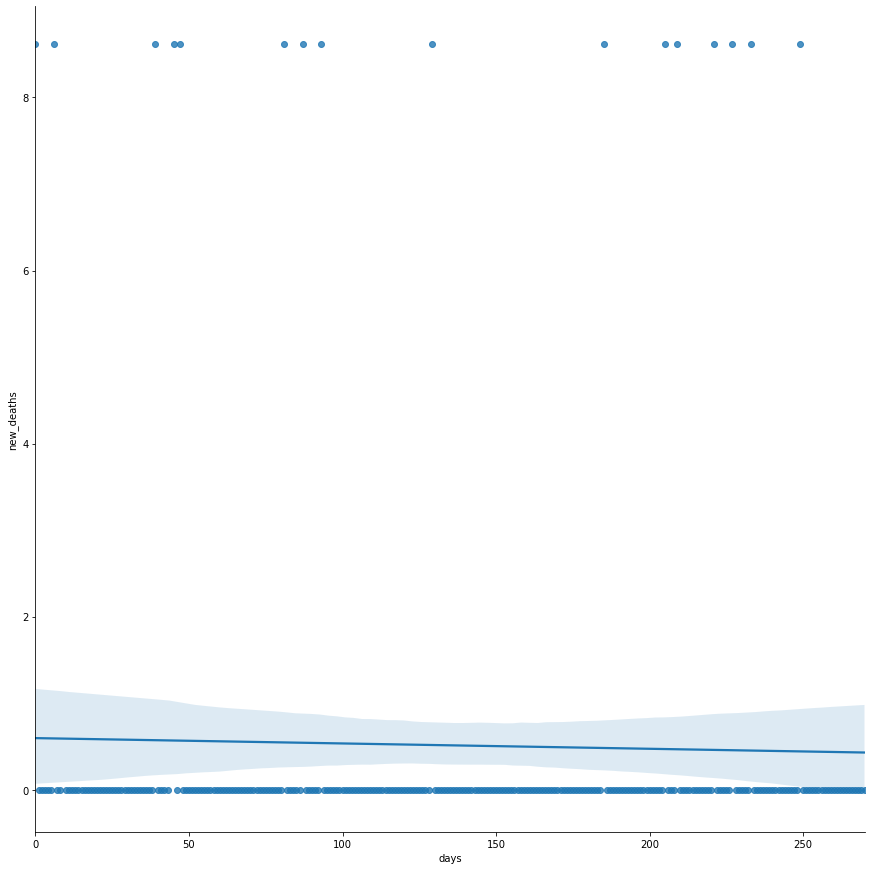

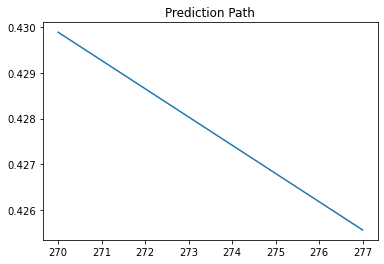

In [61]:
county_deaths_linear(county_deaths(OR[OR['countyFIPS'] == 41049]))

Polynomial 2 model parameters:
 Intercept       0.875572
days           -0.006781
I(days ** 2)    0.000023
dtype: float64

Confidence Intervals:
                      0         1
Intercept     0.135397  1.615747
days         -0.019366  0.005803
I(days ** 2) -0.000022  0.000068

RMSE:  2.0777754366830563


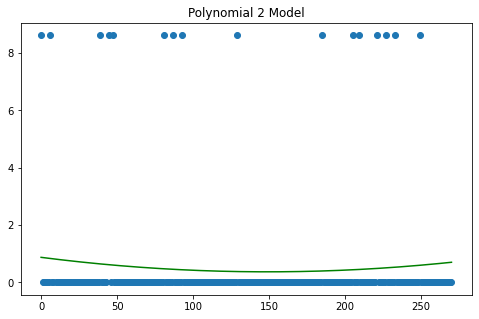

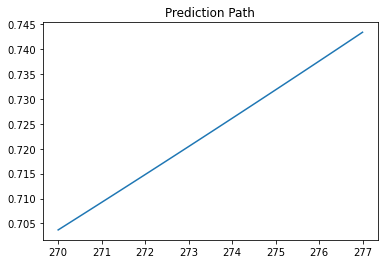

In [62]:
county_deaths_poly2(county_deaths(OR[OR['countyFIPS'] == 41049]))

Polynomial 3 model parameters:
 Intercept       1.196447e+00
days           -2.103824e-02
I(days ** 2)    1.545724e-04
I(days ** 3)   -3.249155e-07
dtype: float64

Confidence Intervals:
                          0             1
Intercept     2.138002e-01  2.179094e+00
days         -5.238848e-02  1.031201e-02
I(days ** 2) -1.146832e-04  4.238281e-04
I(days ** 3) -9.792927e-07  3.294617e-07

RMSE:  3.089735778408155


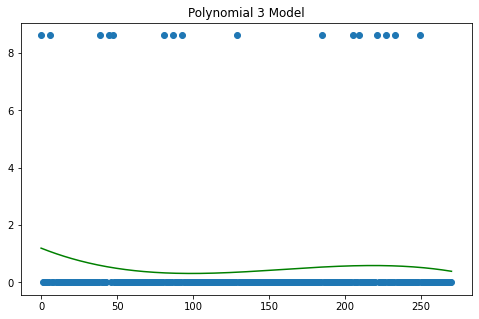

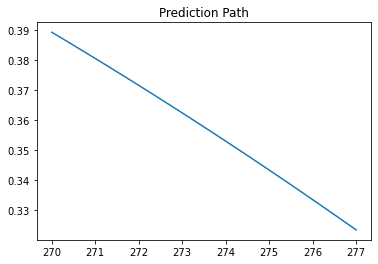

In [63]:
county_deaths_poly3(county_deaths(OR[OR['countyFIPS'] == 41049]))

#### Jefferson County Cases
The linear model indicates that new cases in Jefferson County are increasing, while the polynomial models indicates the number of new cases are decreasing.

Linear model parameters:
 Intercept    5.629377
days         0.111577
dtype: float64

Confidence Intervals:
                   0          1
Intercept -3.365871  14.624625
days       0.065526   0.157629

RMSE:  41.835430013533724


/Users/Erika/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


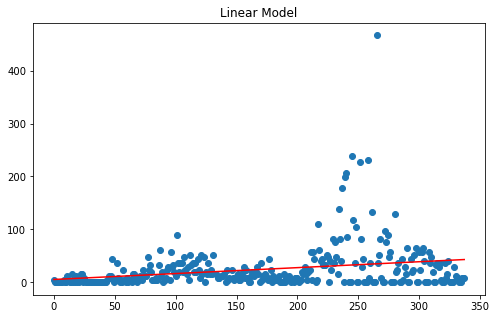

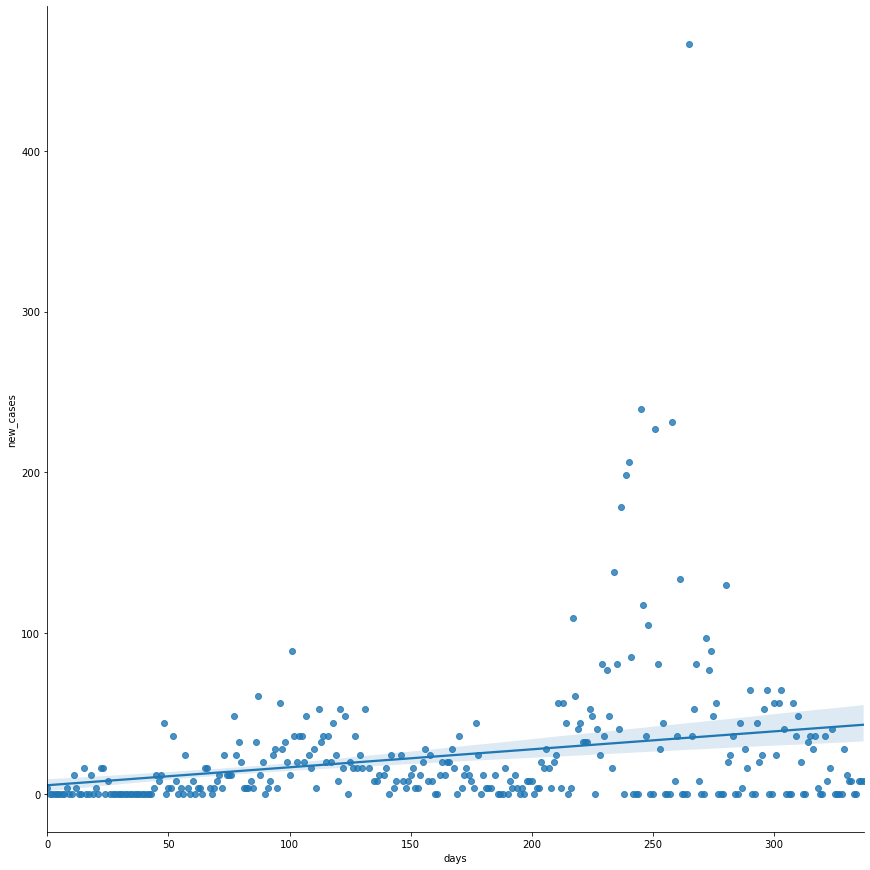

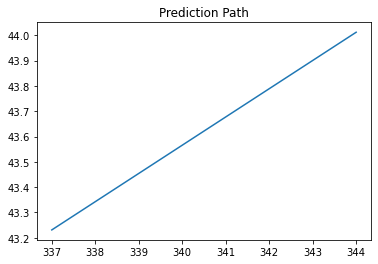

In [64]:
county_cases_linear(county_cases(OR[OR['countyFIPS'] == 41031]))

Polynomial 2 model parameters:
 Intercept      -7.084105
days            0.340581
I(days ** 2)   -0.000680
dtype: float64

Confidence Intervals:
                       0         1
Intercept    -20.378001  6.209792
days           0.157284  0.523878
I(days ** 2)  -0.001207 -0.000153

RMSE:  54.365913850056174


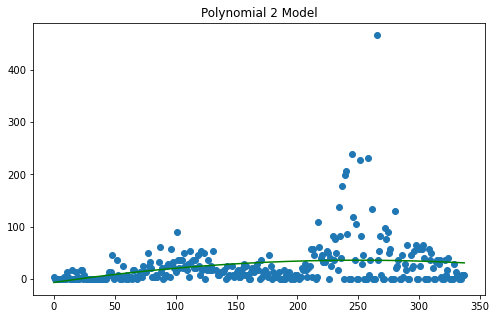

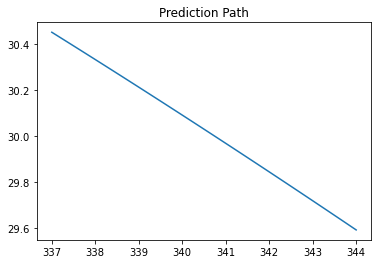

In [65]:
county_cases_poly2(county_cases(OR[OR['countyFIPS'] == 41031]))

Polynomial 3 model parameters:
 Intercept       12.841105
days            -0.375178
I(days ** 2)     0.004630
I(days ** 3)    -0.000010
dtype: float64

Confidence Intervals:
                      0          1
Intercept    -4.541252  30.223461
days         -0.824131   0.073775
I(days ** 2)  0.001536   0.007723
I(days ** 3) -0.000017  -0.000004

RMSE:  97.88632887669274


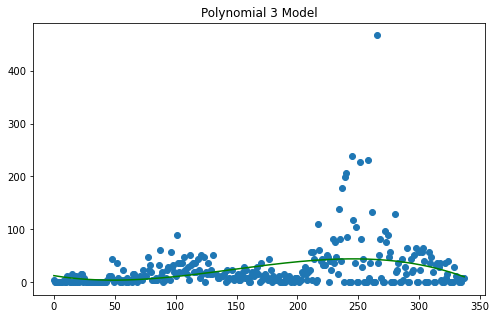

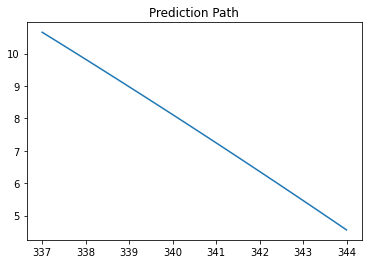

In [66]:
county_cases_poly3(county_cases(OR[OR['countyFIPS'] == 41031]))

#### Jefferson County Deaths
The linear and polynomial 2 models indicate new deaths are increasing in Jefferson County, while the polynomial 3 model indicates that new deaths are decreasing.

Linear model parameters:
 Intercept    0.481812
days         0.000666
dtype: float64

Confidence Intervals:
                   0         1
Intercept  0.024641  0.938982
days      -0.002736  0.004069

RMSE:  1.8121964722526394


/Users/Erika/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


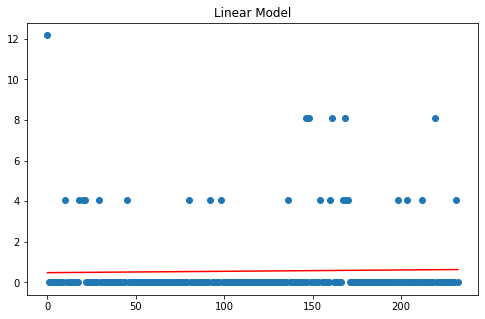

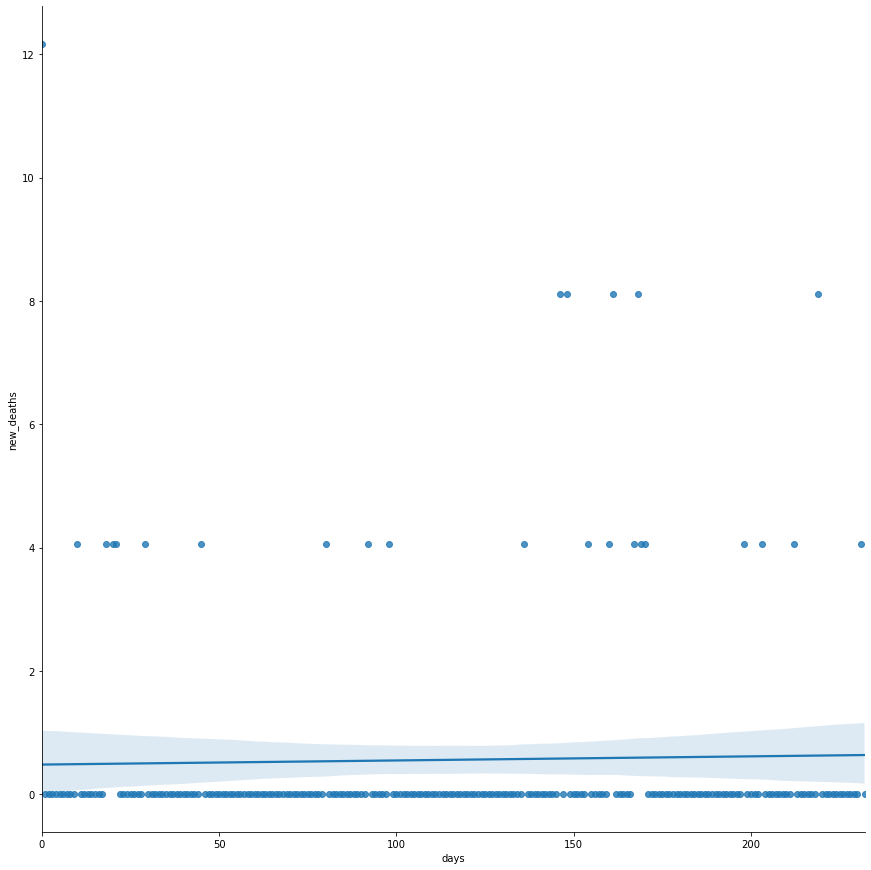

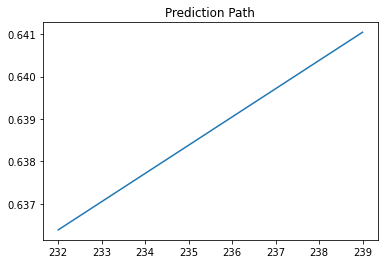

In [67]:
county_deaths_linear(county_deaths(OR[OR['countyFIPS'] == 41031]))

Polynomial 2 model parameters:
 Intercept       0.804086
days           -0.007652
I(days ** 2)    0.000036
dtype: float64

Confidence Intervals:
                      0         1
Intercept     0.120983  1.487189
days         -0.021199  0.005895
I(days ** 2) -0.000021  0.000092

RMSE:  1.8536080410696474


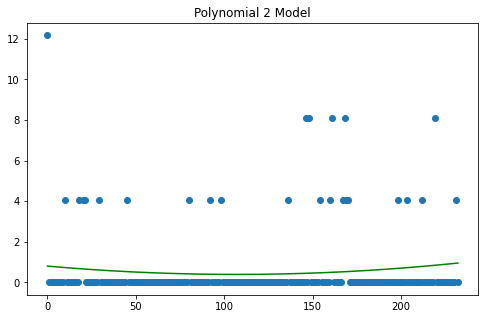

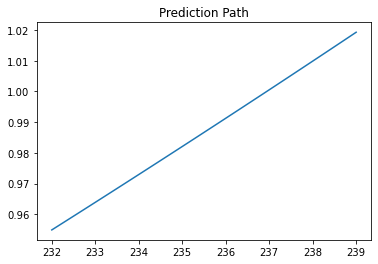

In [68]:
county_deaths_poly2(county_deaths(OR[OR['countyFIPS'] == 41031]))

Polynomial 3 model parameters:
 Intercept       1.597011
days           -0.048953
I(days ** 2)    0.000481
I(days ** 3)   -0.000001
dtype: float64

Confidence Intervals:
                      0             1
Intercept     0.706214  2.487809e+00
days         -0.082102 -1.580396e-02
I(days ** 2)  0.000149  8.132656e-04
I(days ** 3) -0.000002 -3.398029e-07

RMSE:  5.619090933648793


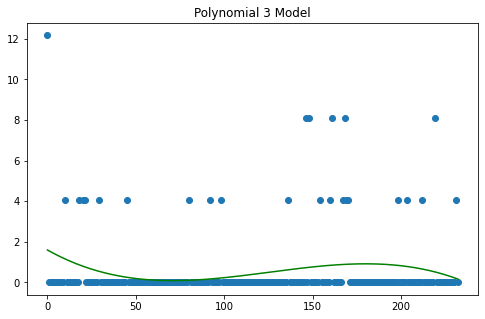

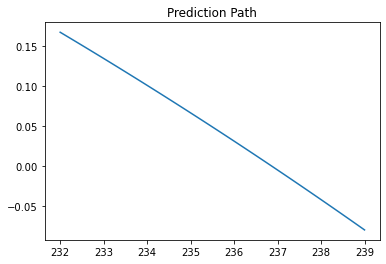

In [69]:
county_deaths_poly3(county_deaths(OR[OR['countyFIPS'] == 41031]))

#### Marion County Cases
The linear model indicates that the new cases in Marion County are increasing, while the polynomial models indicate that the new cases are decreasing.

Linear model parameters:
 Intercept    0.885940
days         0.073676
dtype: float64

Confidence Intervals:
                   0         1
Intercept -3.293353  5.065233
days       0.054350  0.093002

RMSE:  20.561495793589728


/Users/Erika/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


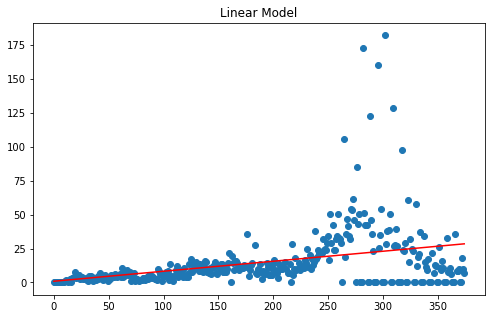

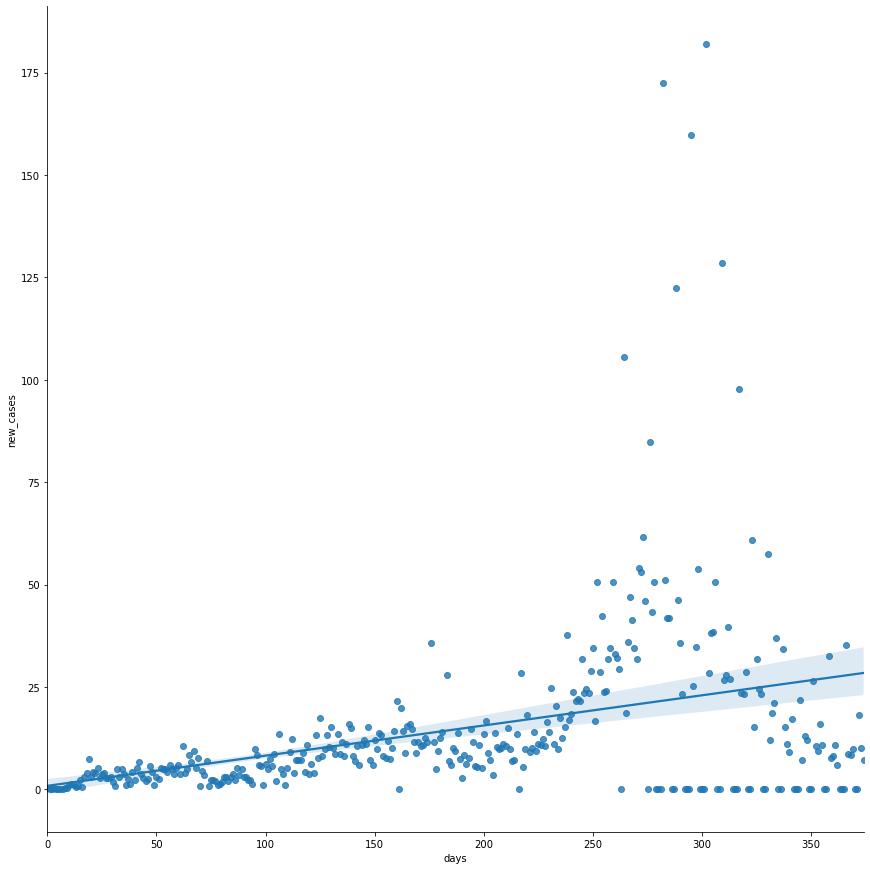

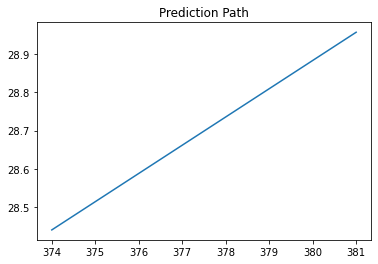

In [70]:
county_cases_linear(county_cases(OR[OR['countyFIPS'] == 41047]))

Polynomial 2 model parameters:
 Intercept      -5.773914
days            0.181119
I(days ** 2)   -0.000287
dtype: float64

Confidence Intervals:
                       0         1
Intercept    -11.960985  0.413157
days           0.104510  0.257729
I(days ** 2)  -0.000486 -0.000089

RMSE:  27.427584553296022


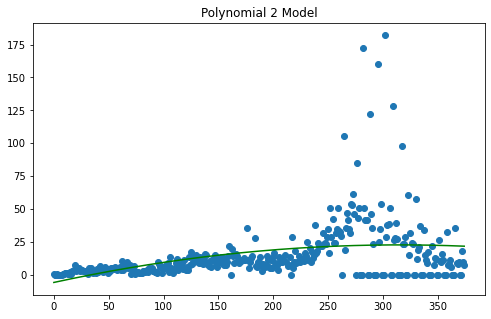

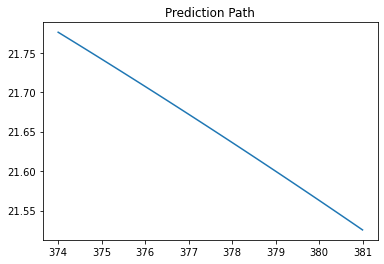

In [71]:
county_cases_poly2(county_cases(OR[OR['countyFIPS'] == 41047]))

Polynomial 3 model parameters:
 Intercept       9.821232
days           -0.322607
I(days ** 2)    0.003083
I(days ** 3)   -0.000006
dtype: float64

Confidence Intervals:
                      0          1
Intercept     1.965341  17.677123
days         -0.504829  -0.140384
I(days ** 2)  0.001951   0.004216
I(days ** 3) -0.000008  -0.000004

RMSE:  80.34831242645613


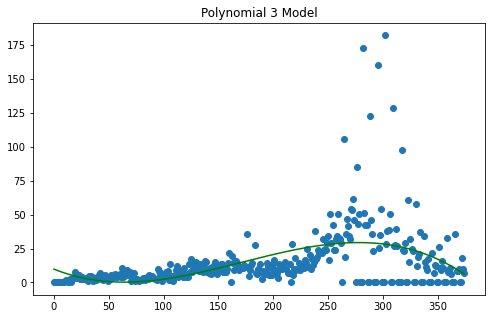

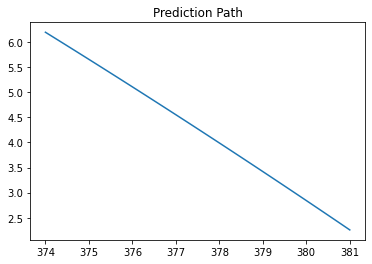

In [72]:
county_cases_poly3(county_cases(OR[OR['countyFIPS'] == 41047]))

#### Marion County Deaths
The linear model indicates that new deaths in Marion County are increasing, while the polynomial 3 model indicates the new deaths are decreasing. The polynomial 2 model seems to show the new deaths as stable or slightly decreasing.

Linear model parameters:
 Intercept    0.078812
days         0.000864
dtype: float64

Confidence Intervals:
                   0         1
Intercept -0.001533  0.159158
days       0.000479  0.001249

RMSE:  0.8627882397230922


/Users/Erika/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


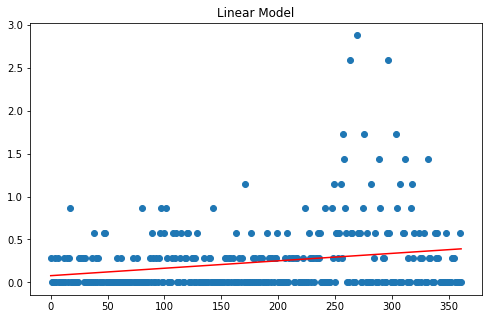

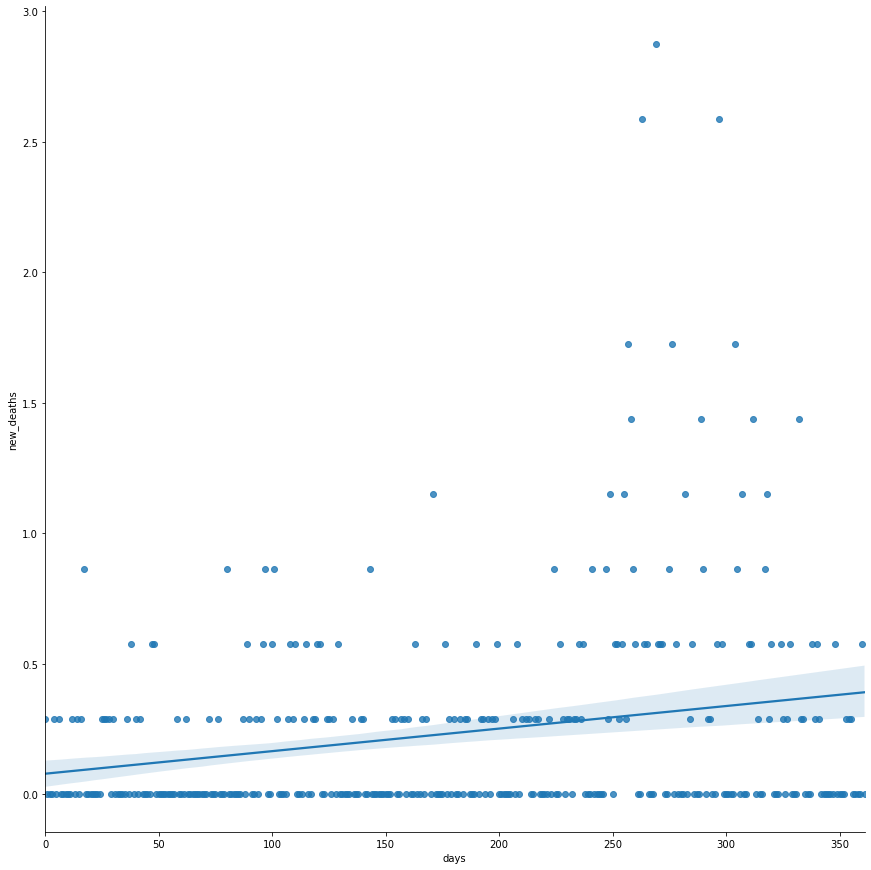

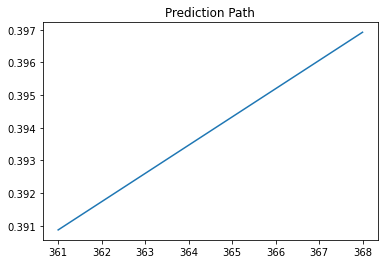

In [73]:
county_deaths_linear(county_deaths(OR[OR['countyFIPS'] == 41047]))

Polynomial 2 model parameters:
 Intercept       0.038303
days            0.001541
I(days ** 2)   -0.000002
dtype: float64

Confidence Intervals:
                          0         1
Intercept    -8.185626e-02  0.158462
days         -2.766268e-08  0.003082
I(days ** 2) -6.007917e-06  0.000002

RMSE:  0.8627882397230922


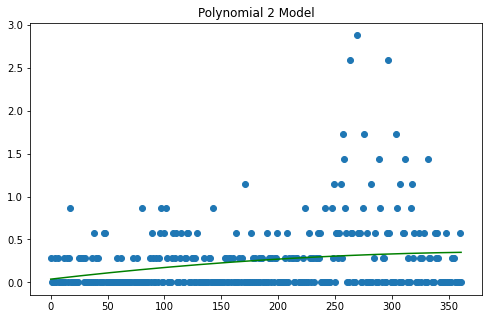

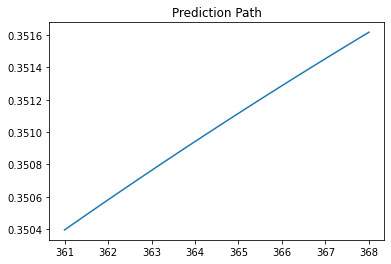

In [74]:
county_deaths_poly2(county_deaths(OR[OR['countyFIPS'] == 41047]))

Polynomial 3 model parameters:
 Intercept       2.207979e-01
days           -4.569584e-03
I(days ** 2)    4.051676e-05
I(days ** 3)   -7.829884e-08
dtype: float64

Confidence Intervals:
                          0             1
Intercept     6.384381e-02  3.777519e-01
days         -8.341158e-03 -7.980108e-04
I(days ** 2)  1.622174e-05  6.481178e-05
I(days ** 3) -1.225386e-07 -3.405905e-08

RMSE:  0.8716450771771083


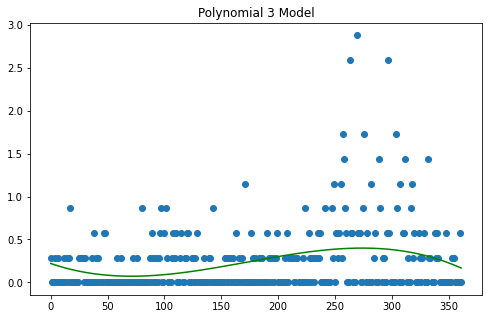

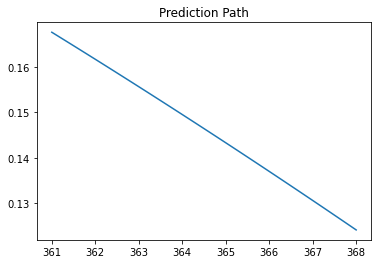

In [75]:
county_deaths_poly3(county_deaths(OR[OR['countyFIPS'] == 41047]))

## Hospital Data and the Point of No Return

In [76]:
hospital_df = pd.read_csv('../../../../data/stage_I/Definitive_Healthcare _USA_Hospital_Beds.csv')
OR_hosp = hospital_df[hospital_df['HQ_STATE'] == 'OR']
OR_hosp.head()

,X,Y,OBJECTID,HOSPITAL_NAME,HOSPITAL_TYPE,HQ_ADDRESS,HQ_ADDRESS1,HQ_CITY,HQ_STATE,HQ_ZIP_CODE,...,CNTY_FIPS,FIPS,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,AVG_VENTILATOR_USAGE,Potential_Increase_In_Bed_Capac
15,-123.365057,43.227069,16,Roseburg VA Health Care System,VA Hospital,913 Nw Garden Valley Blvd,NaN,Roseburg,OR,97471,...,19.0,41019.0,NaN,NaN,0,0,NaN,NaN,0.0,0
3123,-117.847356,44.795005,3124,Saint Alphonsus Medical Center - Baker City,Critical Access Hospital,3325 Pocahontas Rd,NaN,Baker City,OR,97814,...,1.0,41001.0,36.0,21.0,2,2,0.0,0.287019,2.0,15
3124,-123.252700,44.603243,3125,Good Samaritan Regional Medical Center,Short Term Acute Care Hospital,3600 Nw Samaritan Dr,NaN,Corvallis,OR,97330,...,3.0,41003.0,188.0,169.0,12,12,0.0,0.566167,4.0,19
3125,-122.587139,45.356147,3126,Providence Willamette Falls Medical Center,Short Term Acute Care Hospital,1500 Division St,NaN,Oregon City,OR,97045,...,5.0,41005.0,143.0,111.0,8,8,0.0,0.397828,3.0,32
3126,-122.627607,45.449432,3127,Providence Milwaukie Hospital,Short Term Acute Care Hospital,10150 Se 32nd Ave,NaN,Milwaukie,OR,97222,...,5.0,41005.0,77.0,40.0,6,6,0.0,0.605890,2.0,37


Use linear model for new deaths in Oregon.

In [77]:
OR_deaths_lm = smf.ols(formula='new_deaths ~ days', data=OR_deaths2).fit()
OR_deaths_params = OR_deaths_lm.params.to_frame().transpose()

#### Point of No Return

In [78]:
OR_no_return = (OR_hosp['NUM_ICU_BEDS'].sum() - OR_deaths_params['Intercept']) / OR_deaths_params['days']
OR_no_return = np.floor(OR_no_return)
print('The point of no return in Oregon will be ', OR_no_return.to_string(index=False), ' days after the date of the first death in Oregon. This is when the number of new deaths will exceed the ', OR_hosp['NUM_ICU_BEDS'].sum(), ' ICU beds in Oregon if it continues on the same path.')



The point of no return in Oregon will be   22562.0  days after the date of the first death in Oregon. This is when the number of new deaths will exceed the  838  ICU beds in Oregon if it continues on the same path.


#### Function to Get Trends

In [79]:
def deaths(state):
    state_dataset = super_dataset[super_dataset['State'] == state]
    state_deaths = state_dataset[state_dataset.columns[6::2]]

    first_day_deaths = state_deaths.sum() > 0
    first_day_deaths = first_day_deaths[first_day_deaths]
    first_day_deaths = first_day_deaths.index[0]

    state_deaths = state_deaths.loc[:, first_day_deaths:OR_deaths.columns[-1]]

    state_deaths2 = state_deaths.diff(axis=1)
    state_deaths2[first_day_deaths] = state_deaths[first_day_deaths]
    state_deaths2 = state_deaths2.sum(axis=0)
    state_deaths2 = state_deaths2.to_frame()
    state_deaths2 = state_deaths2.reset_index()
    state_deaths2['days'] = state_deaths2.index
    state_deaths2.rename(columns={0:'new_deaths'}, inplace=True)
    state_deaths2 = state_deaths2[(state_deaths2.new_deaths >= 0)]
    state_deaths2['new_deaths'] = (state_deaths2['new_deaths'] / state_dataset['population'].sum()) * 1000000

    state_deaths_lm = smf.ols(formula='new_deaths ~ days', data=OR_deaths2).fit()
    
    plt.figure(figsize=(8 * 1.618, 8))
    plt.scatter(state_deaths2.days, state_deaths2.new_deaths)
    x = pd.DataFrame({'days': np.linspace(state_deaths2.days.min(), state_deaths2.days.max(), state_deaths2.shape[0])})
    x['pred_deaths'] = state_deaths_lm.predict(x)
    plt.plot(x.days, x.pred_deaths, 'r-')

#### Top 5 States Close to Point of No Return
The top 5 states are DE, MD, MA, NJ, and NY

In [80]:
bed_use = hospital_df.groupby('HQ_STATE')['BED_UTILIZATION'].mean().to_frame()
bed_use.nlargest(10, 'BED_UTILIZATION')

,BED_UTILIZATION
HQ_STATE,
GU,0.749779
DC,0.728747
DE,0.711331
MD,0.662845
MA,0.655346
NJ,0.652233
NY,0.620541
VT,0.609327
CT,0.605570


#### Delaware

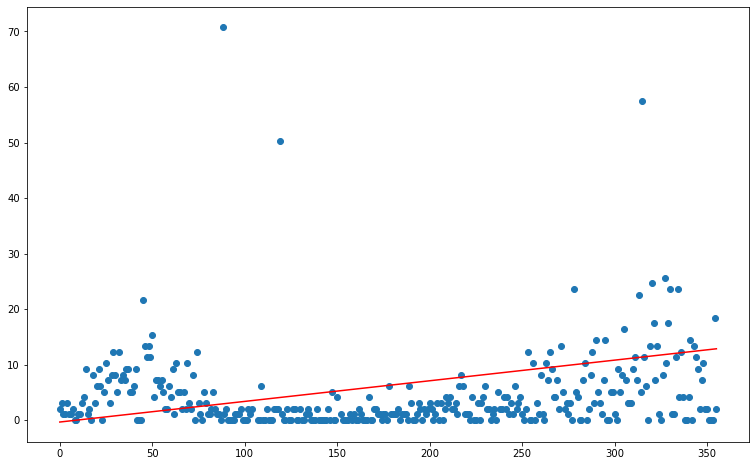

In [81]:
deaths('DE')

#### Maryland

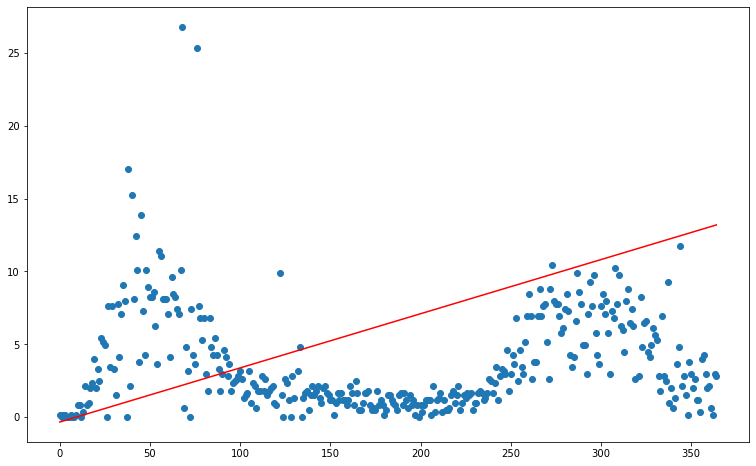

In [82]:
deaths('MD')

#### Massachusetts

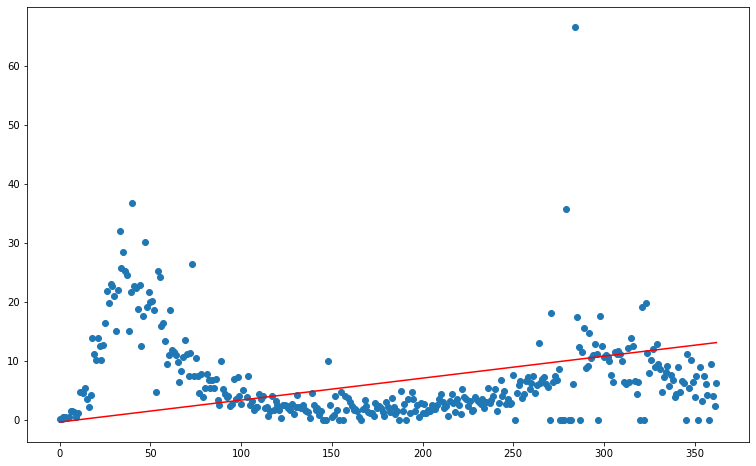

In [83]:
deaths('MA')

#### New Jersey

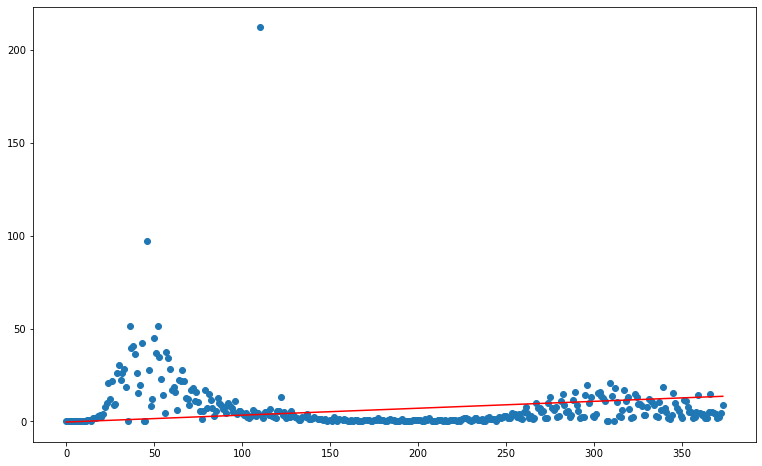

In [84]:
deaths('NJ')

#### New York

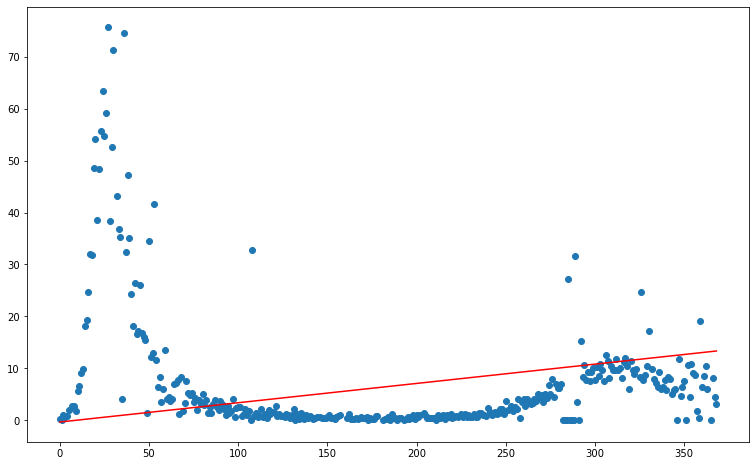

In [85]:
deaths('NY')

## Hypotheses

1.) Does a higher number of voters (normalized) for a certain party lead to a higher initial increase in COVID-19 cases?  
2.) Does a higher number of voters overall(normalized) lead to a higher number of COVID-19 cases overall?(Changed because it was the same as # 3.      
3.) Do counties with a certain party winner have a higher number of COVID-19 cases overall (normalized)?

#### Hypothesis 1:  
Does a higher number of voters (normalized) for a certain party lead to a higher initial increase in COVID-19 cases?

Null Hypothesis: There is no difference in the intial increase in COVID-19 cases between different high voter parties.

NOTE: Comparing the Republican and Democratic party winning counties.

In [86]:
# Import the presidential dataset and merge it with the super dataset.
presidential_df = pd.read_csv('../../../../data/stage_I/president_county_candidate.csv')
state_abbr = pd.read_csv("../../../../data/stage_I/name-abbr.csv", delimiter=",", header=None)

pres_df = presidential_df.merge(state_abbr, left_on = 'state', right_on = 0)
pres_super_dataset = super_dataset.merge(pres_df, left_on = ['State', 'County Name'], right_on = [1, 'county'])

# Get Oregon data only and normalize the number of votes for each county
OR_pres = pres_super_dataset[pres_super_dataset['State'] == 'OR']
OR_pres['norm_votes'] = np.ceil((OR_pres['total_votes'] / OR_pres['population']) * 100000)
OR_pres.head()

<ipython-input-86-1feab7713ad7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OR_pres['norm_votes'] = np.ceil((OR_pres['total_votes'] / OR_pres['population']) * 100000)


,countyFIPS,County Name,State,StateFIPS,population,2020-01-22_cases,2020-01-22_deaths,2020-01-23_cases,2020-01-23_deaths,2020-01-24_cases,...,2021-03-17_deaths,state,county,candidate,party,total_votes,won,0,1,norm_votes
14693,41001,Baker County,OR,41,16124,0,0,0,0,0,...,12,Oregon,Baker County,Donald Trump,REP,7352,True,Oregon,OR,45597.0
14694,41001,Baker County,OR,41,16124,0,0,0,0,0,...,12,Oregon,Baker County,Joe Biden,DEM,2346,False,Oregon,OR,14550.0
14695,41001,Baker County,OR,41,16124,0,0,0,0,0,...,12,Oregon,Baker County,Jo Jorgensen,LIB,144,False,Oregon,OR,894.0
14696,41001,Baker County,OR,41,16124,0,0,0,0,0,...,12,Oregon,Baker County,Write-ins,WRI,41,False,Oregon,OR,255.0
14697,41001,Baker County,OR,41,16124,0,0,0,0,0,...,12,Oregon,Baker County,Howie Hawkins,GRN,33,False,Oregon,OR,205.0


In [87]:
# Get cases information only.
cases = OR_pres[OR_pres.columns[5::2]]
cases = cases[cases.columns[0:-5]]

In [88]:
# Get the first fourth number of days since cases started and calculate the normalized rate of new cases for this time period.
initial_cases = cases[cases.columns[0:(math.ceil(cases.shape[1]/4))]]
OR_pres['initial_rate'] = initial_cases[initial_cases.columns[-1]] / initial_cases.shape[1]
OR_pres['norm_initial_rate'] = (OR_pres['initial_rate'] / OR_pres['population']) * 100000
OR_pres.head()

<ipython-input-88-f8862b7134c2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OR_pres['initial_rate'] = initial_cases[initial_cases.columns[-1]] / initial_cases.shape[1]
<ipython-input-88-f8862b7134c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OR_pres['norm_initial_rate'] = (OR_pres['initial_rate'] / OR_pres['population']) * 100000


,countyFIPS,County Name,State,StateFIPS,population,2020-01-22_cases,2020-01-22_deaths,2020-01-23_cases,2020-01-23_deaths,2020-01-24_cases,...,county,candidate,party,total_votes,won,0,1,norm_votes,initial_rate,norm_initial_rate
14693,41001,Baker County,OR,41,16124,0,0,0,0,0,...,Baker County,Donald Trump,REP,7352,True,Oregon,OR,45597.0,0.009434,0.058509
14694,41001,Baker County,OR,41,16124,0,0,0,0,0,...,Baker County,Joe Biden,DEM,2346,False,Oregon,OR,14550.0,0.009434,0.058509
14695,41001,Baker County,OR,41,16124,0,0,0,0,0,...,Baker County,Jo Jorgensen,LIB,144,False,Oregon,OR,894.0,0.009434,0.058509
14696,41001,Baker County,OR,41,16124,0,0,0,0,0,...,Baker County,Write-ins,WRI,41,False,Oregon,OR,255.0,0.009434,0.058509
14697,41001,Baker County,OR,41,16124,0,0,0,0,0,...,Baker County,Howie Hawkins,GRN,33,False,Oregon,OR,205.0,0.009434,0.058509


In [89]:
# Get the counties with republican and democratic winners.
rep_winners = OR_pres[OR_pres['party'] == 'REP']
rep_winners = rep_winners[rep_winners['won'] == True]

dem_winners = OR_pres[OR_pres['party'] == 'DEM']
dem_winners = dem_winners[dem_winners['won'] == True]

Two-tailed, two-sample t-test.

In [90]:
stats.ttest_ind(a=rep_winners['norm_initial_rate'],
                b=dem_winners['norm_initial_rate'],
                equal_var=False)

Ttest_indResult(statistic=-1.6326380543585448, pvalue=0.12874611615750878)

Hypothesis 1: We fail to reject the null hypothesis as the pvalue is greater than 0.05, so there is no difference in the intial increase in COVID-19 cases between different high voter parties.

#### Hypothesis 2 
(Changed becaue it was pretty much the same as Hypothesis 3):  

Does a higher number of voters overall(normalized) lead to a higher number of COVID-19 cases overall?

Null Hypothesis: There is no difference in the number of overall cases between high and low number of voters.

In [91]:
# Find the total number of normalized votes in each county
county_votes = OR_pres.groupby('countyFIPS')['norm_votes'].sum().to_frame()
county_votes.rename(columns={'norm_votes': 'total_norm_votes'}, inplace=True)
county_votes.reset_index(inplace=True)

# Find the mean of this total number of normalized votes for all counties.
total_counties = OR_pres.merge(county_votes, on='countyFIPS')
mean_votes = total_counties['total_norm_votes'].mean()

# Get the counties with high number of voters and low number of voters as compared to the mean.
low_voters = total_counties[total_counties['total_norm_votes'] < mean_votes]
high_voters = total_counties[total_counties['total_norm_votes'] >= mean_votes]

# Get the column title of the last day of cases.
low_total_case = low_voters.columns[-14]
high_total_case = high_voters.columns[-14]

Two-tailed, two-sample t-test.

In [92]:
stats.ttest_ind(a=low_voters[low_total_case],
                b=high_voters[high_total_case],
                equal_var=False)

Ttest_indResult(statistic=4.640086918671873, pvalue=7.641664899962769e-06)

The p-value is below 0.05, so we can reject the null hypothesis.

The one sample t-test with the higher number of voters had a p-value less than 0.05, which means we can reject the null hypothesis. Since alpha = 0.05, p/2 is also less than alpha and the t-value is positive, we can say that the hypothesis is correct and that a higher number of normalized voters overall leads to a higher number of COVID_19 cases overall.

#### Hypothesis 3: 
Do counties with a certain party winner have a higher number of COVID-19 cases overall (normalized)?

Null Hypothesis: There is no difference in the number of COVID-19 cases overall between party winners.

NOTE: Comparing the Republican and Democratic party winning counties.

In [93]:
rep_cases = (rep_winners[rep_winners.columns[-13]] / rep_winners['population']) * 100000
dem_cases = (dem_winners[dem_winners.columns[-13]] / dem_winners['population']) * 100000

In [94]:
stats.ttest_ind(a=rep_cases,
                b=dem_cases,
                equal_var=False)

Ttest_indResult(statistic=1.433450153812696, pvalue=0.16099613647669822)

The p-value is greater than 0.05, so we fail to reject the null hypothesis.